In [8]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
pd.set_option('display.max_columns', None)

# Î°úÍ∑∏ Î∞è Í≤ΩÍ≥† Ï≤òÎ¶¨
import logging
import warnings
warnings.filterwarnings('ignore')
import os
import sys
sys.path.append('../../../jupyter_WorkingDirectory/UDM/')
import myLib
import pickle  # pickle Î™®Îìà Ï∂îÍ∞Ä

#Prophet
from prophet import Prophet

# ÏßÄÎ¶¨ Ï†ïÎ≥¥ Ï≤òÎ¶¨ ÎùºÏù¥Î∏åÎü¨Î¶¨
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString, box

# ÏãúÍ∞ÅÌôî ÎùºÏù¥Î∏åÎü¨Î¶¨
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager as fm, rc
# ploylt
%matplotlib inline
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)


# ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï
font_path = '/usr/local/src/python3.10/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/KoPub Dotum Medium.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# DB Connect
import psycopg2

# Prophet Ïù¥ÎûÄ?
- ProphetÏùÄ FacebookÏóêÏÑú ÎßåÎì† Ïò§Ìîà ÏÜåÏä§ ÏãúÍ≥ÑÏó¥ ÏòàÏ∏° ÎùºÏù¥Î∏åÎü¨Î¶¨ÏûÖÎãàÎã§.
- Ï£ºÎ°ú ÎπÑÏ¶àÎãàÏä§ ÏòàÏ∏°Ïóê ÎßéÏù¥ ÏÇ¨Ïö©ÎêòÎ©∞, ÏãúÍ∞ÑÏóê Îî∞Îùº Î≥ÄÌôîÌïòÎäî Ìä∏Î†åÎìú, Ï£ºÍ∞Ñ/Ïó∞Í∞Ñ Í≥ÑÏ†àÏÑ±, ÌäπÏ†ï Ïù¥Î≤§Ìä∏/Ìú¥Ïùº Ìö®Í≥º Îì±ÏùÑ Î™®Îç∏ÎßÅÌïòÎäî Îç∞ Í∞ïÏ†êÏùÑ Î≥¥ÏûÖÎãàÎã§.
- Ï£ºÏöî ÌäπÏßï
    - Ïâ¨Ïö¥ ÏÇ¨Ïö©Î≤ï: ProphetÏùÄ ÏÇ¨Ïö©ÏûêÍ∞Ä Î≥µÏû°Ìïú ÏàòÌïôÏ†Å Î™®Îç∏ÏùÑ Ïù¥Ìï¥ÌïòÏßÄ ÏïäÏïÑÎèÑ Í∞ÑÎã®Ìûà ÏòàÏ∏°ÏùÑ ÏàòÌñâÌï† Ïàò ÏûàÏäµÎãàÎã§.
    - ÎπÑÏÑ†Ìòï Ï∂îÏÑ∏ Î™®Îç∏ÎßÅ: ProphetÏùÄ ÏÑ†Ìòï Ïô∏ÏóêÎèÑ ÎπÑÏÑ†Ìòï Ï∂îÏÑ∏Î•º Î™®Îç∏ÎßÅÌï† Ïàò ÏûàÏäµÎãàÎã§.
    - Í≤∞Ï∏°Ïπò Î∞è Ïù¥ÏÉÅÏπòÏóê Í∞ïÌï®: Îç∞Ïù¥ÌÑ∞Ïóê Í≤∞Ï∏°ÏπòÎÇò Ïù¥ÏÉÅÏπòÍ∞Ä ÏûàÏñ¥ÎèÑ ÎπÑÍµêÏ†Å Ïûò Ï≤òÎ¶¨Ìï† Ïàò ÏûàÏäµÎãàÎã§.
    - Í≥ÑÏ†àÏÑ±: Ï£ºÍ∞Ñ, Ïó∞Í∞Ñ Îì± Îã§ÏñëÌïú Í≥ÑÏ†àÏÑ±ÏùÑ ÏûêÎèôÏúºÎ°ú Ï≤òÎ¶¨Ìï† Ïàò ÏûàÏäµÎãàÎã§.
    - ÌäπÏàò Ïù¥Î≤§Ìä∏: Í≥µÌú¥Ïùº, ÌîÑÎ°úÎ™®ÏÖò Îì±Ïùò Ïù¥Î≤§Ìä∏Î•º Î∞òÏòÅÌï† Ïàò ÏûàÏäµÎãàÎã§.

## Prophet ÎÇ¥Î∂Ä ÏàòÌïô(GAM) Í∞úÏöî
- ProphetÏùÄ **Generalized Additive Model(GAM)** Í∏∞Î∞òÏúºÎ°ú, ÏãúÍ≥ÑÏó¥ Í¥ÄÏ∏°Ïπò $y(t)$Î•º Îã§Ïùå ÎÑ§ Í∞ÄÏßÄ Ìï©ÏúºÎ°ú Î™®Îç∏ÎßÅÌï©ÎãàÎã§:
  $$
  y(t) = g(t) + s(t) + h(t) + \varepsilon_t
  $$
- $g(t)$: Ï∂îÏÑ∏ Ìï®Ïàò (trend)  
- $s(t)$: Í≥ÑÏ†àÏÑ± Ìï®Ïàò (seasonality)  
- $h(t)$: Ìú¥Ïùº(holiday) Ìö®Í≥º  
- $\varepsilon_t \sim \mathcal{N}(0, \sigma^2)$$: ÎèÖÎ¶Ω ÎèôÎ∂ÑÏÇ∞ Ïò§Ï∞®  

### 3-1. Ï∂îÏÑ∏ Ìï®Ïàò $g(t)$

1. **ÏÑ†Ìòï(linear) ÏÑ±Ïû•**  
   $$
   g(t) = k \, t + m
   $$
   - $k$: ÏÑ±Ïû•ÏÜçÎèÑ (growth rate)  
   - $m$: Ï†àÌé∏ (intercept)  

2. **Î°úÏßÄÏä§Ìã±(logistic) ÏÑ±Ïû•**  
   $$
   g(t) = \frac{C}{1 + \exp\bigl(-k(t - t_0)\bigr)}
   $$
   - $C$: Ïö©Îüâ (capacity, saturation)  
   - $t_0$: Ï§ëÏã¨Ï†ê (center)  
   - Î™®Îç∏ ÌïôÏäµ Ïãú, Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏóê `cap`¬∑`floor` Ïó¥ÏùÑ Ï∂îÍ∞ÄÌïòÏó¨ ÏÇ¨Ïö©  

3. **Changepoints Ï≤òÎ¶¨**  
   - $S$Í∞úÏùò changepoint $\{\tau_j\}$ÏóêÏÑú ÏÑ±Ïû•ÏÜçÎèÑ Î≥ÄÌôîÎüâ $\delta_j$ ÎèÑÏûÖ  
     $$
     g(t) = \Bigl(k + \sum_{j:\,\tau_j < t} \delta_j\Bigr)\,t 
            \;+\; \Bigl(m - \sum_{j:\,\tau_j < t} \delta_j\,\tau_j\Bigr)
     $$
   - $\delta_j$Ïóê Laplace ÏÇ¨Ï†ÑÎ∂ÑÌè¨ Ï†ÅÏö© ‚Üí `changepoint_prior_scale`Î°ú Ï†úÏñ¥  

### 3-2. Í≥ÑÏ†àÏÑ± Ìï®Ïàò $s(t)$
Fourier Í∏âÏàò(fourier series)Î°ú ÌëúÌòÑ:

$$
s(t) = \sum_{n=1}^{N} \Bigl[a_n \cos\!\bigl(\tfrac{2\pi n t}{P}\bigr) + b_n \sin\!\bigl(\tfrac{2\pi n t}{P}\bigr)\Bigr]
$$

- **ÎÇ¥Ïû• Í≥ÑÏ†àÏÑ±**  
  - Ïó∞Í∞Ñ: $P=365.25, N=10$  
  - Ï£ºÍ∞Ñ: $P=7, N=3$  
  - ÏùºÍ∞Ñ: $P=1, N=3$  
- **ÏÇ¨Ïö©Ïûê Ï†ïÏùò**  
  ```python
  m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
  ```
### 3-3. Ìú¥Ïùº Ìö®Í≥º Ìï®Ïàò $h(t)$
Ìú¥Ïùº Î¶¨Ïä§Ìä∏ $H = \{d_h\}$Ïóê Îî∞Îùº:

$$
h(t) = \sum_{h \in H} \alpha_h \, I_h(t)
$$

- $I_h(t)$: ÏßÄÌëú Ìï®Ïàò, $t$Í∞Ä Ìú¥Ïùº $d_h$Ïù¥Î©¥ 1, ÏïÑÎãàÎ©¥ 0  
- $\alpha_h$: Ìú¥Ïùº Ìö®Í≥º ÌÅ¨Í∏∞ (impact)  
- `m.add_country_holidays('KR')` ÎòêÎäî Ïª§Ïä§ÌÖÄ Ìú¥Ïùº Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏúºÎ°ú ÌôïÏû• Í∞ÄÎä•  
- Ìú¥Ïùº Ìö®Í≥ºÏóêÎèÑ Laplace ÏÇ¨Ï†ÑÎ∂ÑÌè¨ Ï†ÅÏö© ‚Üí Í≥ºÏ†ÅÌï© ÏñµÏ†ú
### 3-4. ÌååÎùºÎØ∏ÌÑ∞ Ï∂îÏ†ï Î∞è Î∂àÌôïÏã§ÏÑ±
- **MAP Ï∂îÏ†ï**: Stan Î∞±ÏóîÎìúÎ•º Ïù¥Ïö©Ìï¥ ÏµúÎåÄ a posteriori Ï†ê Ï∂îÏ†ï  
- **Î∂àÌôïÏã§ÏÑ± ÏÉòÌîåÎßÅ**:  
  - `uncertainty_samples` Í∞úÏàòÎßåÌÅº ÏãúÎÆ¨Î†àÏù¥ÏÖò  
  - `interval_width`Î°ú ÏòàÏ∏° Íµ¨Í∞Ñ Ìè≠ Ï°∞Ï†ï  
### 3-5. Ïô∏Î∂Ä ÌöåÍ∑ÄÎ≥ÄÏàò(ÌöåÍ∑ÄÌï≠) ÌÜµÌï©
GAM Íµ¨Ï°∞Î•º ÌôúÏö©ÌïòÏó¨:

$$
y(t) = g(t) + s(t) + h(t) + \sum_{k} \beta_k \, X_k(t) + \varepsilon_t
$$

- `m.add_regressor('temp')` Îì±ÏúºÎ°ú ÌöåÍ∑ÄÎ≥ÄÏàò Ï∂îÍ∞Ä  
- Ïä§ÏºÄÏùºÎßÅ¬∑Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨ ÌïÑÏàò  
- ÌöåÍ∑ÄÍ≥ÑÏàò $\beta_k$Îäî Gaussian ÏÇ¨Ï†ÑÎ∂ÑÌè¨ ÏïÑÎûò ÌïôÏäµ  


# ProphetÏùò Í∏∞Î≥∏ ÏÇ¨Ïö©Î≤ïÍ≥º ÏõêÎ¶¨ Ïù¥Ìï¥
- ProphetÏùÄ Îëê Í∞úÏùò Ï£ºÏöî Ïª¨Îüº(ds, y)Ïù¥ Ìè¨Ìï®Îêú Îç∞Ïù¥ÌÑ∞ ÌîÑÎ†àÏûÑÏùÑ ÏûÖÎ†•Î∞õÏäµÎãàÎã§.
- ds: ÎÇ†Ïßú/ÏãúÍ∞ÑÏùÑ ÎÇòÌÉÄÎÇ¥Îäî Ïª¨Îüº (ÌÉÄÏûÖ: datetime)
- y: ÏòàÏ∏°ÌïòÎ†§Îäî Í∞í (ÌÉÄÏûÖ: float)

In [13]:
# Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
df = pd.DataFrame({
    'ds': pd.to_datetime(pd.date_range(start='2021-01-01',end='2021-10-31')),
    'y': np.random.randint(100,500,size=len(pd.date_range(start='2021-01-01',end='2021-10-31')))
})

# Î™®Îç∏ ÏÉùÏÑ±
model = Prophet()

# Î™®Îç∏ ÌïôÏäµ
model.fit(df)

# ÏòàÏ∏°Ìï† ÎÇ†Ïßú ÏÉùÏÑ± (Ïòà: 1Ïùº ÌõÑ ÏòàÏ∏°)
future = model.make_future_dataframe(periods=61)

# ÏòàÏ∏°
forecast = model.predict(future)

2025-04-04 11:04:37,225 - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2025-04-04 11:04:37,226 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2025-04-04 11:04:37,230 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/h2m3yt6d.json
2025-04-04 11:04:37,232 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/gefbsm_o.json
2025-04-04 11:04:37,233 - DEBUG - idx 0
2025-04-04 11:04:37,233 - DEBUG - running CmdStan, num_threads: None
2025-04-04 11:04:37,233 - DEBUG - CmdStan args: ['/usr/local/src/python3.10/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13519', 'data', 'file=/tmp/tmp1zhw1ynh/h2m3yt6d.json', 'init=/tmp/tmp1zhw1ynh/gefbsm_o.json', 'output', 'file=/tmp/tmp1zhw1ynh/prophet_modelue87rcha/prophet_model-20250404110437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:04:37 - cmdstanpy - INFO - Chain [1] start processing
2025-04-04 11:04:37,233 - INFO - C

- yhat: ÏòàÏ∏°Í∞í
- yhat_lower: ÏòàÏ∏°Í∞íÏùò ÌïòÌïú (Ïã†Î¢∞ Íµ¨Í∞Ñ)
- yhat_upper: ÏòàÏ∏°Í∞íÏùò ÏÉÅÌïú (Ïã†Î¢∞ Íµ¨Í∞Ñ)

In [14]:
# ÏòàÏ∏° Í≤∞Í≥º Ï∂úÎ†•
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

ds        yhat  yhat_lower  yhat_upper
0   2021-01-01  285.814611  139.663936  441.276628
1   2021-01-02  292.603576  141.386608  453.732999
2   2021-01-03  303.168972  153.273530  449.546788
3   2021-01-04  311.328301  148.139643  465.663021
4   2021-01-05  338.763578  185.835658  491.428984
..         ...         ...         ...         ...
360 2021-12-27  302.594813  149.538070  469.609942
361 2021-12-28  330.030090  170.744496  483.324295
362 2021-12-29  275.049708  127.541484  432.146903
363 2021-12-30  290.029594  142.382101  444.082147
364 2021-12-31  276.909879  124.467080  424.402541

[365 rows x 4 columns]

## Î™®Îç∏Ïùò Íµ¨ÏÑ±ÏöîÏÜå Î∞è ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ Ï°∞Ï†ï
- Îã§Ïùå Îã®Í≥ÑÏóêÏÑúÎäî Prophet Î™®Îç∏Ïùò ÏÑ∏Î∂ÄÏ†ÅÏù∏ Íµ¨ÏÑ± ÏöîÏÜåÏôÄ ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ Ï°∞Ï†ïÏóê ÎåÄÌï¥ Î∞∞ÏõåÎ≥¥Í≤†ÏäµÎãàÎã§.
1. Ï∂îÏÑ∏(Trend) Ï°∞Ï†ï
    - ProphetÏùÄ Í∏∞Î≥∏Ï†ÅÏúºÎ°ú ÏÑ†Ìòï Ï∂îÏÑ∏Î•º Î™®Îç∏ÎßÅÌï©ÎãàÎã§.
    - Í∑∏Îü¨ÎÇò Îç∞Ïù¥ÌÑ∞Í∞Ä Í∏âÍ≤©ÌïòÍ≤å Î≥ÄÌôîÌïòÎäî Í≤ΩÏö∞, Î°úÏßÄÏä§Ìã± Ï∂îÏÑ∏Î•º ÏÇ¨Ïö©Ìï† Ïàò ÏûàÏäµÎãàÎã§.
    - Î°úÏßÄÏä§Ìã± Ï∂îÏÑ∏Î•º ÏÇ¨Ïö©ÌïòÎ†§Î©¥ growth='logistic' ÏòµÏÖòÏùÑ Ï∂îÍ∞ÄÌïòÍ≥†, cap(ÏÉÅÌïú) Í∞íÏùÑ ÏÑ§Ï†ïÌï¥Ïïº Ìï©ÎãàÎã§.
2. Í≥ÑÏ†àÏÑ±(Seasonality) Ï°∞Ï†ï
    - ProphetÏùÄ Í∏∞Î≥∏Ï†ÅÏúºÎ°ú Ïó∞Í∞Ñ, Ï£ºÍ∞Ñ Í≥ÑÏ†àÏÑ±ÏùÑ ÏûêÎèôÏúºÎ°ú Î™®Îç∏ÎßÅÌï©ÎãàÎã§. Ï∂îÍ∞ÄÏ†ÅÏúºÎ°ú ÏÇ¨Ïö©Ïûê Ï†ïÏùò Í≥ÑÏ†àÏÑ±ÏùÑ ÏÑ§Ï†ïÌï† ÏàòÎèÑ ÏûàÏäµÎãàÎã§.
3. Ìú¥Ïùº(Holidays) Ìö®Í≥º Î∞òÏòÅ
    - Í≥µÌú¥ÏùºÏù¥ÎÇò ÌäπÏ†ï Ïù¥Î≤§Ìä∏Í∞Ä ÏòàÏ∏°Ïóê Ï§ëÏöîÌïú ÏòÅÌñ•ÏùÑ ÎØ∏Ïπ† Í≤ΩÏö∞, Ïù¥Î•º Î™®Îç∏Ïóê Î∞òÏòÅÌï† Ïàò ÏûàÏäµÎãàÎã§.
    - ÏòàÎ•º Îì§Ïñ¥, ÌÅ¨Î¶¨Ïä§ÎßàÏä§ÏôÄ Í∞ôÏùÄ Í≥µÌú¥ÏùºÏùÑ Î∞òÏòÅÌïòÎ†§Î©¥ ÏïÑÎûòÏôÄ Í∞ôÏù¥ Ìú¥ÏùºÏùÑ ÏÑ§Ï†ïÌï† Ïàò ÏûàÏäµÎãàÎã§.

## ProphetÏùò ÎÇ¥Î∂Ä Ìú¥Ïùº(Holidays) ÏÑ§Ï†ï Î©îÏÑúÎìú
- ProphetÏùÄ ÎØ∏Î¶¨ Ï†ïÏùòÎêú Ìú¥ÏùºÏùÑ Ï†úÍ≥µÌïòÎäî Ìï®ÏàòÍ∞Ä Í∏∞Î≥∏Ï†ÅÏúºÎ°ú ÎÇ¥Ïû•ÎêòÏñ¥ ÏûàÏßÄÎäî ÏïäÏßÄÎßå, ***add_country_holidays*** ÎùºÎäî Î©îÏÑúÎìúÎ•º Ïù¥Ïö©ÌïòÏó¨ ÌäπÏ†ï Íµ≠Í∞ÄÏùò Ï£ºÏöî Í≥µÌú¥ÏùºÏùÑ Prophet Î™®Îç∏Ïóê ÏâΩÍ≤å Ï∂îÍ∞ÄÌï† Ïàò ÏûàÏäµÎãàÎã§.

In [15]:
# Î™®Îç∏ ÏÉùÏÑ±
model = Prophet()

# Íµ≠Í∞ÄÎ≥Ñ Ìú¥Ïùº ÏûêÎèô Ï∂îÍ∞Ä (Ïòà: ÌïúÍµ≠Ïùò Í≥µÌú¥Ïùº)
model.add_country_holidays(country_name='KR')

# Î™®Îç∏ ÌïôÏäµ
model.fit(df)

2025-04-04 13:58:26,250 - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2025-04-04 13:58:26,251 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2025-04-04 13:58:26,258 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/9lezs05q.json
2025-04-04 13:58:26,263 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/5cx3g2p4.json
2025-04-04 13:58:26,264 - DEBUG - idx 0
2025-04-04 13:58:26,264 - DEBUG - running CmdStan, num_threads: None
2025-04-04 13:58:26,264 - DEBUG - CmdStan args: ['/usr/local/src/python3.10/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18097', 'data', 'file=/tmp/tmp1zhw1ynh/9lezs05q.json', 'init=/tmp/tmp1zhw1ynh/5cx3g2p4.json', 'output', 'file=/tmp/tmp1zhw1ynh/prophet_modelwp_hmlf9/prophet_model-20250404135826.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:58:26 - cmdstanpy - INFO - Chain [1] start processing
2025-04-04 13:58:26,264 - INFO - C

In [16]:
# Ï∂îÍ∞ÄÎêú Ìú¥Ïùº Î™©Î°ù ÌôïÏù∏
model.train_holiday_names

0                                      New Year's Day
1                                     Korean New Year
2                   The day preceding Korean New Year
3                   The second day of Korean New Year
4                           Independence Movement Day
5                                   Buddha's Birthday
6                                      Children's Day
7                                        Memorial Day
8                                      Liberation Day
9                             National Foundation Day
10                                         Hangul Day
11                                            Chuseok
12                          The day preceding Chuseok
13                          The second day of Chuseok
14                                      Christmas Day
15             Alternative holiday for Liberation Day
16    Alternative holiday for National Foundation Day
17                 Alternative holiday for Hangul Day
dtype: object

In [22]:
# Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ (ÎûúÎç§ Îç∞Ïù¥ÌÑ∞ ÏòàÏãú)
df = pd.DataFrame({
    'ds': pd.date_range(start='2021-01-01', end='2021-10-31'),
    'y': np.random.randint(100, 500, size=len(pd.date_range(start='2021-01-01', end='2021-10-31')))
})

# Î™®Îç∏ ÏÉùÏÑ± Î∞è Ìú¥Ïùº Ï∂îÍ∞Ä (ÌïúÍµ≠)
model = Prophet()
model.add_country_holidays(country_name='KR')

# Î™®Îç∏ ÌïôÏäµ
model.fit(df)

# ÏòàÏ∏°Ìï† ÎØ∏Îûò ÎÇ†Ïßú ÏÉùÏÑ±
future = model.make_future_dataframe(periods=61) #Ïó∞ÎßêÍπåÏßÄ

# ÏòàÏ∏°
forecast = model.predict(future)

# ÏòàÏ∏° Í≤∞Í≥º ÌôïÏù∏ (ÎßàÏßÄÎßâ 30Ïùº)
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5))

2025-04-04 14:02:01,353 - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2025-04-04 14:02:01,353 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2025-04-04 14:02:01,360 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/csd6d4hb.json
2025-04-04 14:02:01,365 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/pnx1ua4l.json
2025-04-04 14:02:01,365 - DEBUG - idx 0
2025-04-04 14:02:01,365 - DEBUG - running CmdStan, num_threads: None
2025-04-04 14:02:01,365 - DEBUG - CmdStan args: ['/usr/local/src/python3.10/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82932', 'data', 'file=/tmp/tmp1zhw1ynh/csd6d4hb.json', 'init=/tmp/tmp1zhw1ynh/pnx1ua4l.json', 'output', 'file=/tmp/tmp1zhw1ynh/prophet_modelc0vj6w51/prophet_model-20250404140201.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:02:01 - cmdstanpy - INFO - Chain [1] start processing
2025-04-04 14:02:01,366 - INFO - C

ds        yhat  yhat_lower  yhat_upper
360 2021-12-27  284.235251  140.749733  428.603000
361 2021-12-28  298.427374  156.505627  438.559804
362 2021-12-29  298.929881  169.504369  448.957312
363 2021-12-30  271.139302  130.373174  412.716524
364 2021-12-31  280.451420  131.070415  414.742517

## Í≥µÏãù ÌäúÌÜ†Î¶¨Ïñº ÏòàÏ†ú

In [3]:
# Í≥µÏãù ÌäúÌÜ†Î¶¨Ïñº Airline Passengers Îç∞Ïù¥ÌÑ∞
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
df.head()

ds         y
0  2007-12-10  9.590761
1  2007-12-11  8.519590
2  2007-12-12  8.183677
3  2007-12-13  8.072467
4  2007-12-14  7.893572

13:16:37 - cmdstanpy - INFO - Chain [1] start processing
13:16:37 - cmdstanpy - INFO - Chain [1] done processing


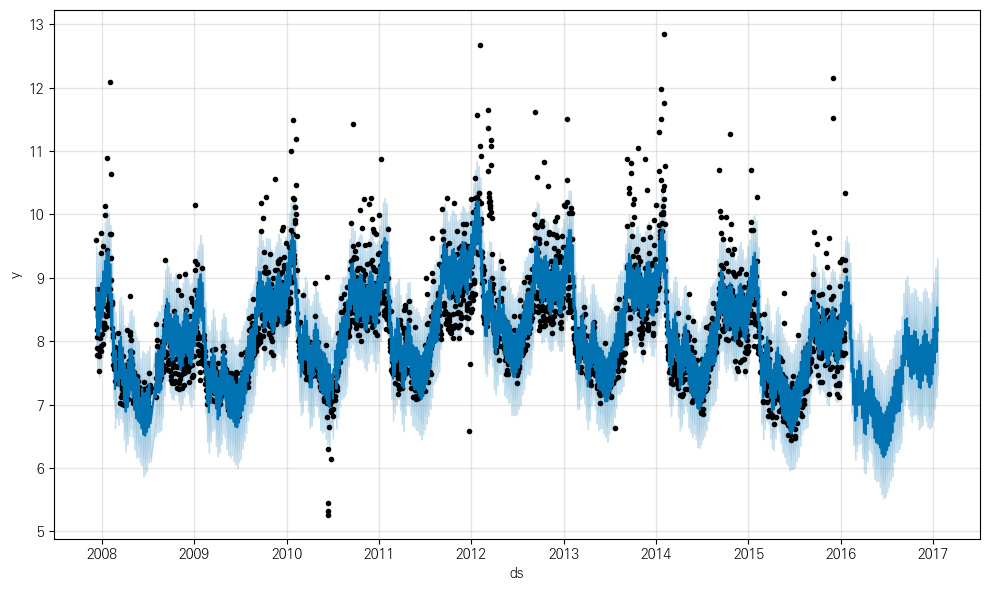

In [4]:
## 1-3. Î™®Îç∏ ÌïôÏäµ Î∞è ÏòàÏ∏°
m = Prophet()
m.fit(df)

future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

fig1 = m.plot(forecast)
plt.show()

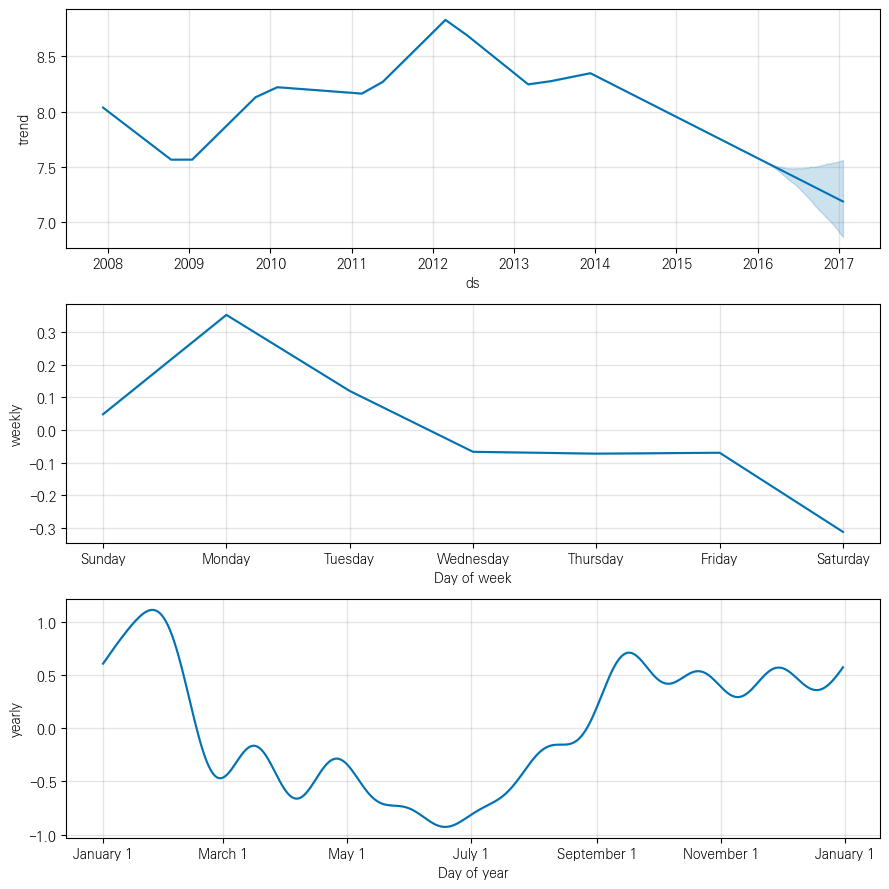

In [7]:
## 1-4. Ïª¥Ìè¨ÎÑåÌä∏ ÏãúÍ∞ÅÌôî
m.
fig2 = m.plot_components(forecast)
plt.show()

# ProphetÏùò Ïã¨Ï∏µÏ†Å ÌôúÏö© Î∞è Í≤∞Í≥º Ìï¥ÏÑù

## üìå 1. ÏòàÏ∏° Í≤∞Í≥º ÏãúÍ∞ÅÌôî (model.plot())
model.plot() Î©îÏÑúÎìúÎ•º ÏÇ¨Ïö©ÌïòÏó¨ ProphetÏùò ÏòàÏ∏° Í≤∞Í≥ºÎ•º ÏãúÍ∞ÅÌôîÌï† Ïàò ÏûàÏäµÎãàÎã§. Ïù¥ Î©îÏÑúÎìúÎäî ÏòàÏ∏°Îêú Îç∞Ïù¥ÌÑ∞ÏôÄ Ïã§Ï†ú Îç∞Ïù¥ÌÑ∞Î•º ÏãúÍ∞ÅÏ†ÅÏúºÎ°ú ÎπÑÍµêÌï¥Ï§çÎãàÎã§.

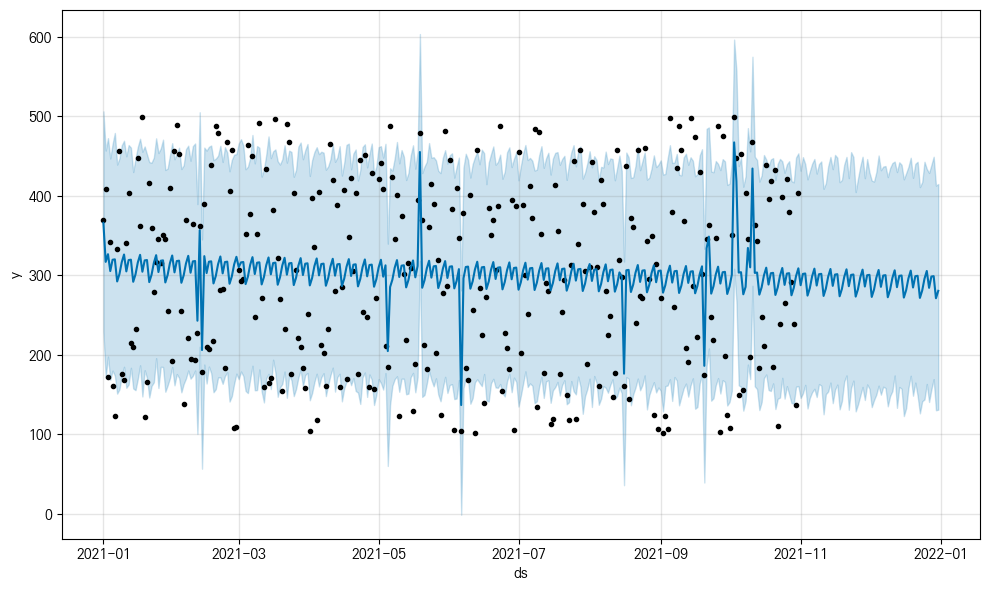

In [37]:
# ÏòàÏ∏° Í≤∞Í≥º ÏãúÍ∞ÅÌôî
fig = model.plot(forecast)
plt.show()

## üìå 2. ProphetÏùò Íµ¨ÏÑ± ÏöîÏÜå ÏãúÍ∞ÅÌôî (model.plot_components())
- model.plot_components() Î©îÏÑúÎìúÎäî ÏòàÏ∏° Í≤∞Í≥ºÎ•º Íµ¨ÏÑ±ÌïòÎäî Îã§ÏñëÌïú ÏöîÏÜå(Ï∂îÏÑ∏, Í≥ÑÏ†àÏÑ±, Ìú¥Ïùº Ìö®Í≥º Îì±)Î•º Í∞úÎ≥ÑÏ†ÅÏúºÎ°ú ÏãúÍ∞ÅÌôîÌï©ÎãàÎã§.
- Prophet Î™®Îç∏ÏóêÏÑú Ï∂îÏÑ∏ÏôÄ Í≥ÑÏ†àÏÑ±ÏùÑ ÏãúÍ∞ÅÏ†ÅÏúºÎ°ú Î∂ÑÏÑùÌï† Ïàò ÏûàÎäî Ïú†Ïö©Ìïú Î∞©Î≤ïÏûÖÎãàÎã§.
### Íµ¨ÏÑ± ÏöîÏÜå Î∂ÑÏÑù
- Ï∂îÏÑ∏(Trend): Îç∞Ïù¥ÌÑ∞Ïùò Ï†ÑÎ∞òÏ†ÅÏù∏ ÏÉÅÏäπ/ÌïòÍ∞ï Ï∂îÏÑ∏Î•º Î≥¥Ïó¨Ï§çÎãàÎã§.
- Ï£ºÍ∞Ñ(Weekly) Î∞è Ïó∞Í∞Ñ(Yearly) Í≥ÑÏ†àÏÑ±: Ï£ºÍ∞Ñ Î∞è Ïó∞Í∞Ñ Ìå®ÌÑ¥ÏùÑ Î∂ÑÎ¶¨ÌïòÏó¨ ÏãúÍ∞ÅÌôîÌï©ÎãàÎã§.
- Ìú¥Ïùº Ìö®Í≥º(Holidays): ÏßÄÏ†ïÎêú Ìú¥ÏùºÏù¥ ÏòàÏ∏°Ïóê ÎØ∏Ïπú ÏòÅÌñ•ÏùÑ Î≥¥Ïó¨Ï§çÎãàÎã§.
Ïù¥ Î©îÏÑúÎìúÎ•º ÌÜµÌï¥ ÏòàÏ∏°Ïùò Í∞Å Íµ¨ÏÑ± ÏöîÏÜåÍ∞Ä Ïñ¥ÎñªÍ≤å Î™®Îç∏Ïóê Î∞òÏòÅÎêòÏóàÎäîÏßÄ Î∂ÑÏÑùÌï† Ïàò ÏûàÏäµÎãàÎã§.

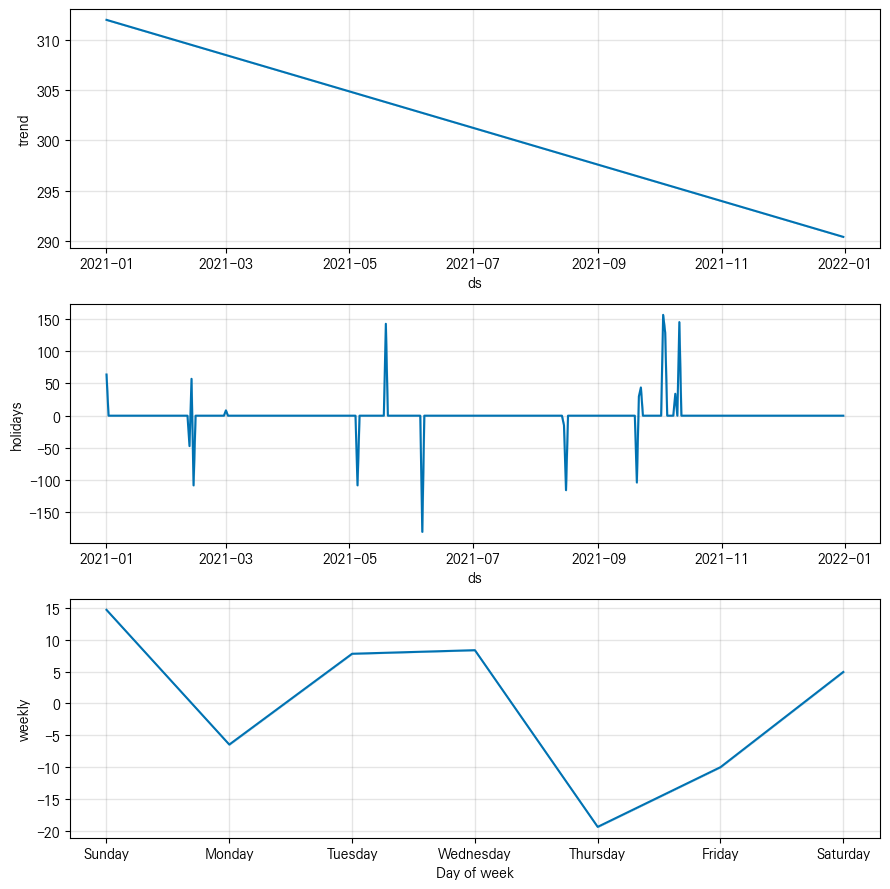

In [38]:
# ProphetÏùò Í∞Å Íµ¨ÏÑ± ÏöîÏÜå (Ï∂îÏÑ∏, Í≥ÑÏ†àÏÑ± Îì±) ÏãúÍ∞ÅÌôî
fig2 = model.plot_components(forecast)
plt.show()

## üìå 3. add_changepoints_to_plotÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ Prophet ÏòàÏ∏° Í∑∏ÎûòÌîÑÏóê Î≥ÄÌôîÏ†ê(changepoints)ÏùÑ Ï∂îÍ∞Ä

- add_changepoints_to_plotÎäî ProphetÏù¥ ÏòàÏ∏°ÌïòÎäî ÎèôÏïà Ï∞æÏùÄ **Î≥ÄÌôîÏ†ê(changepoints)** ÏùÑ ÏãúÍ∞ÅÌôîÌïòÏó¨ Ï∂îÏÑ∏Í∞Ä Î≥ÄÌïòÎäî ÏßÄÏ†êÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÎèÑÎ°ù Ìï¥Ï§çÎãàÎã§.

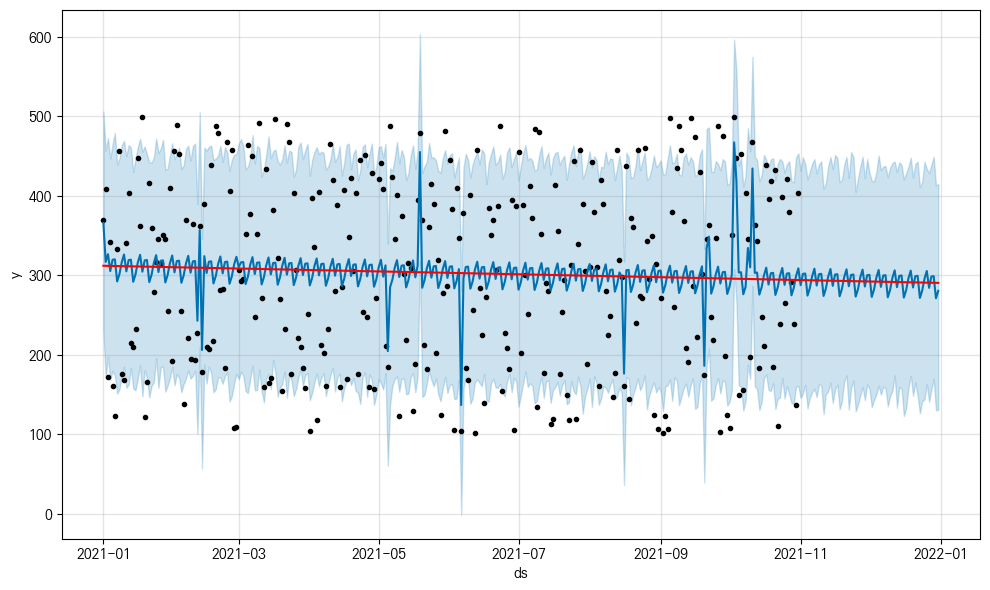

In [41]:
from prophet.plot import add_changepoints_to_plot

# ÏòàÏ∏° Í≤∞Í≥º ÏãúÍ∞ÅÌôî (Ï†ÑÏ≤¥ ÏòàÏ∏°)
fig = model.plot(forecast)

# Î≥ÄÌôîÏ†ê Ï∂îÍ∞Ä (Ï∂îÏÑ∏Í∞Ä Î∞îÎÄåÎäî ÏßÄÏ†ê ÌëúÏãú)
add_changepoints_to_plot(fig.gca(), model, forecast)

# Í∑∏ÎûòÌîÑ Ï∂úÎ†•
plt.show()

# Prophet Î™®Îç∏ Í≥†Í∏â Í∏∞Îä• Î∞è ÏÑ±Îä• ÏµúÏ†ÅÌôî

## üìå1. Î≥ÄÏàò Ï∂îÍ∞Ä Î∞è Îã§Î≥ÄÎüâ ÏòàÏ∏° (Regressors ÏÇ¨Ïö©)
- Ïù¥Î°†Ï†Å Î∞∞Í≤Ω
    - ProphetÏùÄ Îã®Î≥ÄÎüâ ÏãúÍ≥ÑÏó¥ ÏòàÏ∏°Ïóê ÏµúÏ†ÅÌôîÎêòÏñ¥ ÏûàÏßÄÎßå, Îã§Î≥ÄÎüâ ÏãúÍ≥ÑÏó¥ ÏòàÏ∏°ÏùÑ Ìï† Ïàò ÏûàÎèÑÎ°ù Ïô∏Î∂Ä Î≥ÄÏàòÎ•º Ï∂îÍ∞ÄÌï† Ïàò ÏûàÏäµÎãàÎã§.
    - Ïù¥Î•º ÌÜµÌï¥ ProphetÏùÄ Îã§Î•∏ ÏòàÏ∏°Ïóê ÏòÅÌñ•ÏùÑ ÎØ∏ÏπòÎäî Ïô∏Î∂Ä ÏöîÏù∏Îì§ÏùÑ Î∞òÏòÅÌï† Ïàò ÏûàÏäµÎãàÎã§.
    - Ïô∏Î∂Ä Î≥ÄÏàò (External Regressors)
        - Ïô∏Î∂Ä Î≥ÄÏàòÎäî Prophet Î™®Îç∏Ïóê Ï∂îÍ∞ÄÎêòÏñ¥ ÏòàÏ∏°Í∞íÏóê ÏòÅÌñ•ÏùÑ ÎØ∏ÏπòÎäî Î≥ÄÏàòÎì§ÏûÖÎãàÎã§. ÏòàÎ•º Îì§Ïñ¥, ÎÇ†Ïî®, ÎßàÏºÄÌåÖ Ï∫†ÌéòÏù∏, Í≤ΩÏ†ú ÏßÄÌëú Îì±Ïù¥ Îê† Ïàò ÏûàÏäµÎãàÎã§.
    - Regressor Ï∂îÍ∞Ä Î∞©Î≤ï
        - add_regressor() Î©îÏÑúÎìúÎ•º ÏÇ¨Ïö©ÌïòÏó¨ Ïô∏Î∂Ä Î≥ÄÏàòÎ•º Î™®Îç∏Ïóê Ï∂îÍ∞ÄÌï† Ïàò ÏûàÏäµÎãàÎã§.
        - ProphetÏùÄ Ïù¥ Î≥ÄÏàòÎ•º ÏãúÍ≥ÑÏó¥ ÏòàÏ∏° Î™®Îç∏Ïóê ÌÜµÌï©ÌïòÏó¨ ÏòàÏ∏° Ï†ïÌôïÎèÑÎ•º Ìñ•ÏÉÅÏãúÌÇ¨ Ïàò ÏûàÏäµÎãàÎã§.
- Ïù¥Î°†Ï†ÅÏù∏ ÏÑ§Î™Ö
    - Ïô∏Î∂Ä Î≥ÄÏàò (External Regressors): ProphetÏùÄ Í∏∞Î≥∏Ï†ÅÏúºÎ°ú Îã®Î≥ÄÎüâ ÏãúÍ≥ÑÏó¥ ÏòàÏ∏°Ïóê Ï†ÅÌï©ÌïòÏßÄÎßå, Ïô∏Î∂Ä Î≥ÄÏàò(Ïòà: ÎÇ†Ïî®, Í≤ΩÏ†ú ÏßÄÌëú, ÎßàÏºÄÌåÖ Ï∫†ÌéòÏù∏ Îì±)Î•º Ï∂îÍ∞ÄÌïòÏó¨ Îã§Î≥ÄÎüâ ÏãúÍ≥ÑÏó¥ ÏòàÏ∏°ÏùÑ Ìï† Ïàò ÏûàÏäµÎãàÎã§. Ïô∏Î∂Ä Î≥ÄÏàòÎäî ÏòàÏ∏°Ïóê ÏòÅÌñ•ÏùÑ ÎØ∏ÏπòÎäî ÏöîÏù∏Îì§ÏùÑ Î™®Îç∏Ïóê Î∞òÏòÅÌïòÏó¨ ÏòàÏ∏° Ï†ïÌôïÎèÑÎ•º ÎÜíÏù¥Îäî Îç∞ ÎèÑÏõÄÏùÑ Ï§çÎãàÎã§.
    - ÏÑ†Ìòï ÌöåÍ∑Ä Î™®Îç∏ (Linear Regression): ProphetÏùÄ ÎÇ¥Î∂ÄÏ†ÅÏúºÎ°ú ÏÑ†Ìòï ÌöåÍ∑Ä Î™®Îç∏ÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ Ï∂îÏÑ∏Î•º ÏòàÏ∏°Ìï©ÎãàÎã§. Ïô∏Î∂Ä Î≥ÄÏàòÎ•º Ï∂îÍ∞ÄÌïòÎ©¥, ProphetÏùÄ Ïù¥ Ïô∏Î∂Ä Î≥ÄÏàòÏôÄ ÏòàÏ∏° ÎåÄÏÉÅ Î≥ÄÏàò Í∞ÑÏùò Í¥ÄÍ≥ÑÎ•º ÌïôÏäµÌïòÏó¨ ÏòàÏ∏°Ïóê Î∞òÏòÅÌï©ÎãàÎã§.
    - add_regressor() Î©îÏÑúÎìú: Prophet Î™®Îç∏Ïóê Ïô∏Î∂Ä Î≥ÄÏàòÎ•º Ï∂îÍ∞ÄÌïòÎäî Îç∞ ÏÇ¨Ïö©Îê©ÎãàÎã§. Ïù¥ Î©îÏÑúÎìúÎ•º ÏÇ¨Ïö©ÌïòÎ©¥ Ïô∏Î∂Ä Î≥ÄÏàòÎ•º Prophet Î™®Îç∏Ïóê Ï∂îÍ∞ÄÌïòÏó¨ ÏòàÏ∏° Ï†ïÌôïÎèÑÎ•º Ìñ•ÏÉÅÏãúÌÇ¨ Ïàò ÏûàÏäµÎãàÎã§.

2025-04-04 15:28:24,178 - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2025-04-04 15:28:24,179 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2025-04-04 15:28:24,183 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/2r8barhs.json
2025-04-04 15:28:24,186 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/y1h3elsu.json
2025-04-04 15:28:24,186 - DEBUG - idx 0
2025-04-04 15:28:24,186 - DEBUG - running CmdStan, num_threads: None
2025-04-04 15:28:24,186 - DEBUG - CmdStan args: ['/usr/local/src/python3.10/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24309', 'data', 'file=/tmp/tmp1zhw1ynh/2r8barhs.json', 'init=/tmp/tmp1zhw1ynh/y1h3elsu.json', 'output', 'file=/tmp/tmp1zhw1ynh/prophet_modelx5ozyrcw/prophet_model-20250404152824.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:24 - cmdstanpy - INFO - Chain [1] start processing
2025-04-04 15:28:24,186 - INFO - C

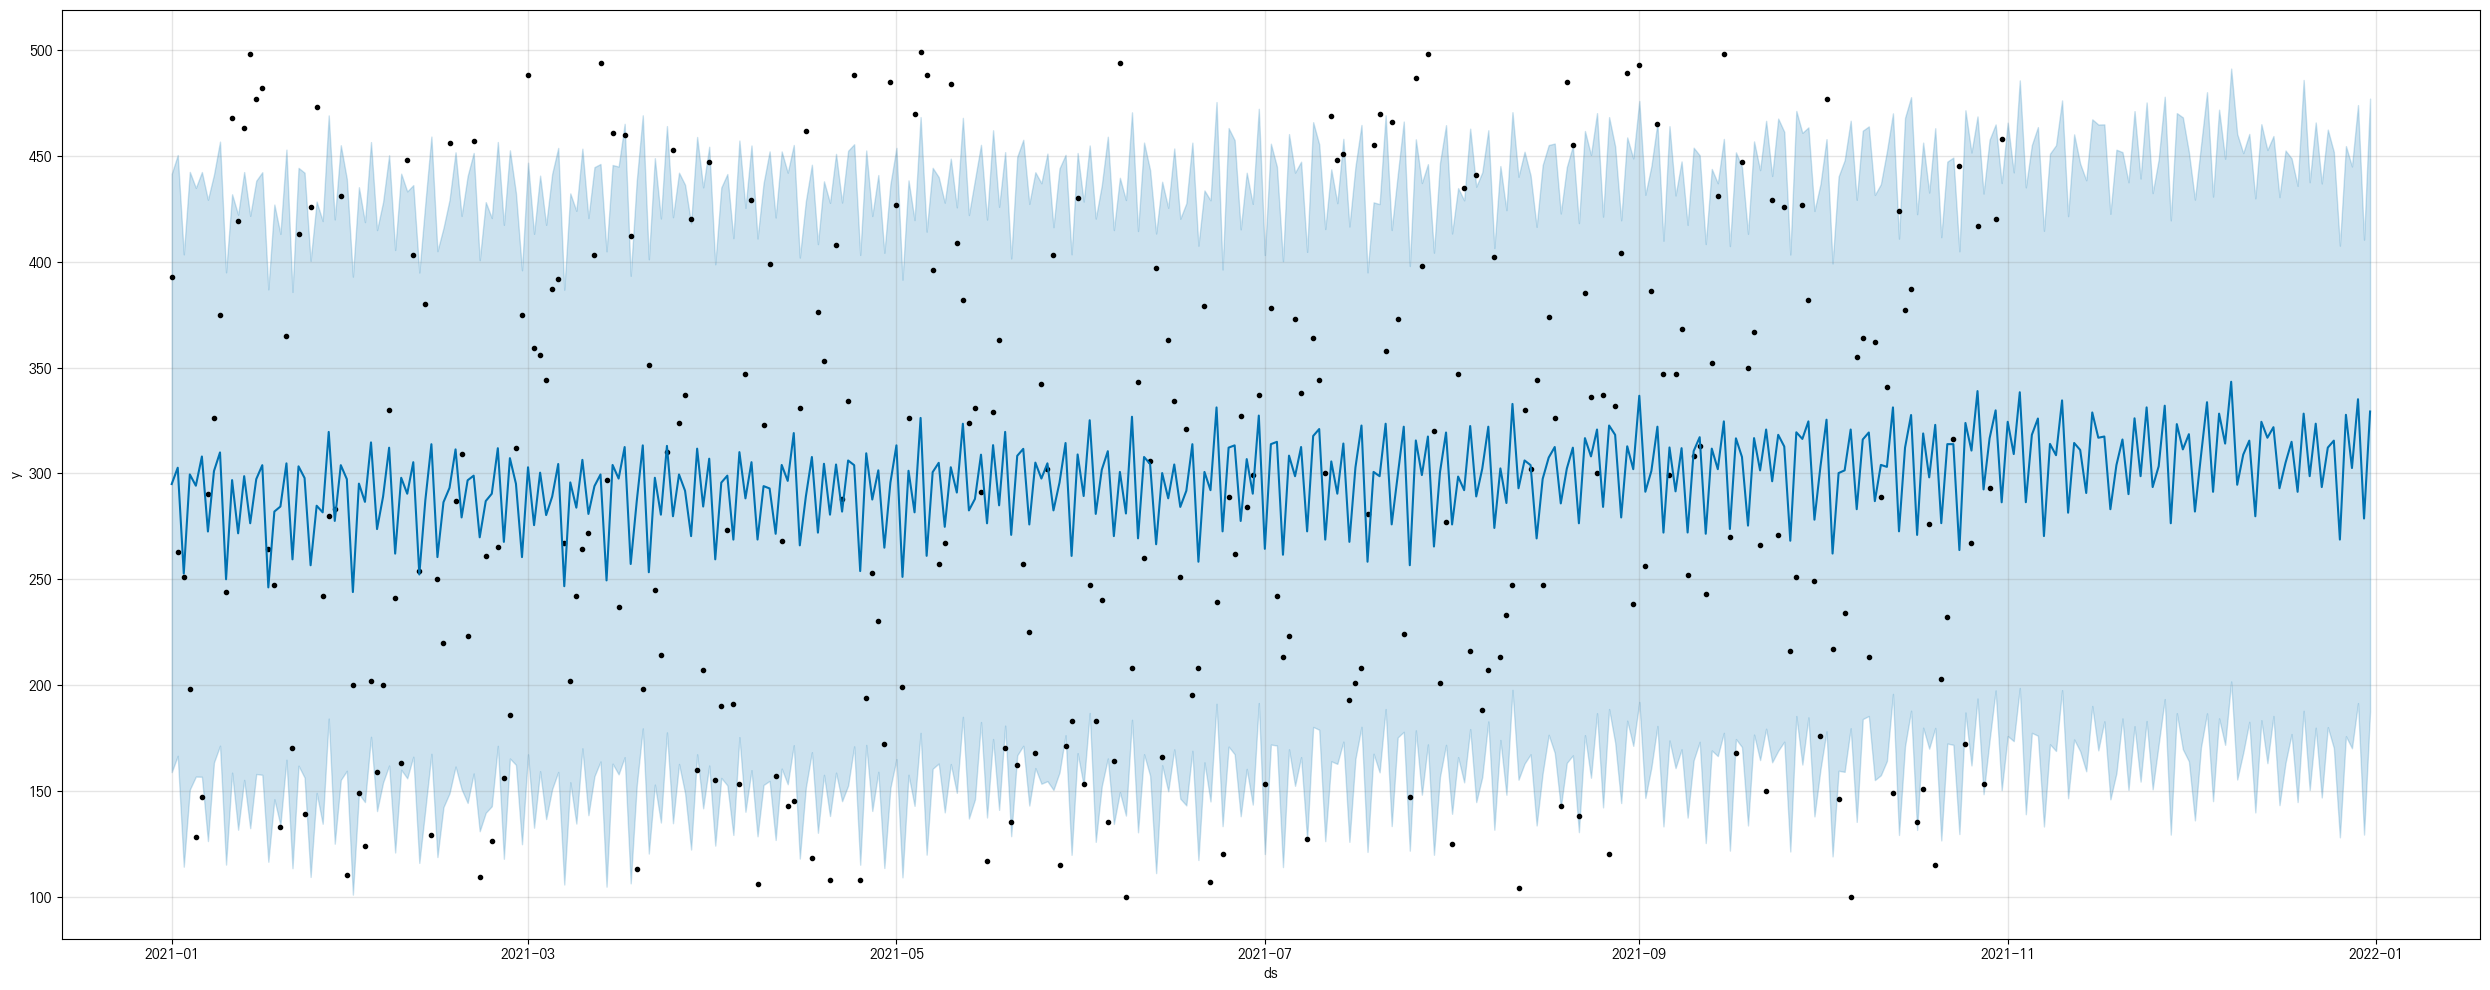

In [44]:
# Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ (ÎûúÎç§ Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±)
df = pd.DataFrame({
    'ds': pd.date_range(start='2021-01-01', end='2021-10-31'),
    'y': np.random.randint(100, 500, size=len(pd.date_range(start='2021-01-01', end='2021-10-31')))
})

# Ïô∏Î∂Ä Î≥ÄÏàò Ï∂îÍ∞Ä (Ïò®ÎèÑ Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±)
df['temp'] = np.random.randint(10, 35, size=len(df))  # 10ÎèÑÏóêÏÑú 35ÎèÑ ÏÇ¨Ïù¥Ïùò ÎûúÎç§ Ïò®ÎèÑ Í∞í

# Î™®Îç∏ ÏÉùÏÑ±
model = Prophet()

# Ïô∏Î∂Ä Î≥ÄÏàò Ï∂îÍ∞Ä
model.add_regressor('temp')

# Î™®Îç∏ ÌïôÏäµ
model.fit(df)

# ÏòàÏ∏°Ìï† ÎØ∏Îûò ÎÇ†Ïßú ÏÉùÏÑ± (Ïó∞ÎßêÍπåÏßÄ ÏòàÏ∏°)
future = model.make_future_dataframe(periods=61)

# ÎØ∏Îûò Îç∞Ïù¥ÌÑ∞Ïóê Ïô∏Î∂Ä Î≥ÄÏàò(temp) Ï∂îÍ∞Ä
future['temp'] = np.random.randint(10, 35, size=len(future))  # ÎØ∏ÎûòÏùò Ïò®ÎèÑ Í∞í Ï∂îÍ∞Ä

# ÏòàÏ∏°
forecast = model.predict(future)

# ÏòàÏ∏° Í≤∞Í≥º ÏãúÍ∞ÅÌôî
fig = model.plot(forecast, figsize=(25, 10))
plt.show()

ÌöåÍ∑Ä Î∂ÑÏÑùÏóêÏÑú Ïô∏Î∂Ä Î≥ÄÏàò Ï∂îÍ∞ÄÏùò Ï§ëÏöîÏÑ±: Ïô∏Î∂Ä Î≥ÄÏàòÎ•º Ï∂îÍ∞ÄÌïòÎäî Ïù¥Ïú†Îäî ÏòàÏ∏°Ïùò Ï†ïÌôïÎèÑÎ•º ÎÜíÏù¥Í∏∞ ÏúÑÌï¥ÏÑúÏûÖÎãàÎã§. Ïô∏Î∂Ä Î≥ÄÏàòÎäî ÏãúÍ≥ÑÏó¥ Ìå®ÌÑ¥ÏùÑ ÏÑ§Î™ÖÌïòÎäî Îç∞ ÎèÑÏõÄÏùÑ Ï£ºÎ©∞, ÏòàÏ∏° ÎåÄÏÉÅ Î≥ÄÏàòÏôÄ ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÍ∞Ä ÏûàÏùÑ Îïå Ïú†Ïö©Ìï©ÎãàÎã§. ProphetÏùÄ ÎÇ¥Î∂ÄÏ†ÅÏúºÎ°ú Ïô∏Î∂Ä Î≥ÄÏàòÏôÄ ÏòàÏ∏° ÎåÄÏÉÅ Í∞ÑÏùò Í¥ÄÍ≥ÑÎ•º ÌïôÏäµÌïòÏó¨ ÏòàÏ∏°Ïóê Î∞òÏòÅÌï©ÎãàÎã§.

Ïô∏Î∂Ä Î≥ÄÏàòÏùò Ìö®Í≥º: Prophet Î™®Îç∏ÏóêÏÑú Ïô∏Î∂Ä Î≥ÄÏàòÎ•º Ï∂îÍ∞ÄÌïòÎ©¥, Ïù¥ Î≥ÄÏàòÏùò Î≥ÄÌôîÍ∞Ä ÏòàÏ∏°Ïóê Ïñ¥ÎñªÍ≤å ÏòÅÌñ•ÏùÑ ÎØ∏ÏπòÎäîÏßÄÎ•º ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§. ÏòàÎ•º Îì§Ïñ¥, Ïò®ÎèÑÍ∞Ä ÏòàÏ∏° ÎåÄÏÉÅ Î≥ÄÏàòÏóê ÏòÅÌñ•ÏùÑ ÎØ∏ÏπúÎã§Î©¥, Ïò®ÎèÑÍ∞Ä ÎÜíÏùÑ Îïå ÌåêÎß§ÎüâÏù¥ Ï¶ùÍ∞ÄÌïòÎäî Îì±Ïùò Ìå®ÌÑ¥ÏùÑ Î∞òÏòÅÌï† Ïàò ÏûàÏäµÎãàÎã§.

### ‚úÖ Îã§Î≥ÄÎüâ ÏòàÏ∏°ÏóêÏÑúÏùò Í≥†Î†§ÏÇ¨Ìï≠
- ÌöåÍ∑Ä Î≥ÄÏàòÏùò Ï§ëÏöîÏÑ±:
    - Ïô∏Î∂Ä Î≥ÄÏàòÎäî ÏòàÏ∏°Ìï† Î≥ÄÏàòÏôÄ ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÍ∞Ä ÏûàÏñ¥Ïïº Ìï©ÎãàÎã§. ÏòàÎ•º Îì§Ïñ¥, ÌåêÎß§ÎüâÍ≥º Ïò®ÎèÑÎäî ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÍ∞Ä ÏûàÏùÑ Ïàò ÏûàÏäµÎãàÎã§. ÎòêÌïú, ÎßàÏºÄÌåÖ ÎπÑÏö©Í≥º ÌåêÎß§Îüâ Í∞ÑÏóêÎèÑ Í¥ÄÍ≥ÑÍ∞Ä ÏûàÏùÑ Ïàò ÏûàÏäµÎãàÎã§.
    - ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÍ∞Ä ÏïΩÌïú Î≥ÄÏàòÎ•º Ï∂îÍ∞ÄÌïòÎ©¥ Î™®Îç∏Ïùò ÏÑ±Îä•Ïù¥ Ïò§ÌûàÎ†§ ÎÇÆÏïÑÏßà Ïàò ÏûàÍ∏∞ ÎïåÎ¨∏Ïóê, Î≥ÄÏàò ÏÑ†ÌÉùÏù¥ Îß§Ïö∞ Ï§ëÏöîÌï©ÎãàÎã§.
- Ïô∏Î∂Ä Î≥ÄÏàòÏùò Ï∂îÍ∞Ä:
    - Ïô∏Î∂Ä Î≥ÄÏàòÎ•º Ï∂îÍ∞ÄÌïòÎ©¥ ÏòàÏ∏° Ï†ïÌôïÎèÑÎ•º ÎÜíÏùº Ïàò ÏûàÏäµÎãàÎã§. ÏòàÎ•º Îì§Ïñ¥, Í¥ëÍ≥†ÎπÑ, Í∏∞Ïò®, ÌîÑÎ°úÎ™®ÏÖò Ïù¥Î≤§Ìä∏ Îì±Ïùò Î≥ÄÏàòÍ∞Ä ÌåêÎß§Îüâ ÏòàÏ∏°Ïóê Ï§ëÏöîÌïú ÏòÅÌñ•ÏùÑ ÎØ∏Ïπ† Ïàò ÏûàÏäµÎãàÎã§.
    - ÌïòÏßÄÎßå Î™®Îì† Ïô∏Î∂Ä Î≥ÄÏàòÍ∞Ä Ìï≠ÏÉÅ Ïú†Ïö©Ìïú Í≤ÉÏùÄ ÏïÑÎãàÍ∏∞ ÎïåÎ¨∏Ïóê, Ï†ÅÏ†àÌïú Î≥ÄÏàò ÏÑ†ÌÉùÍ≥º Î™®Îç∏ ÌäúÎãùÏù¥ Ï§ëÏöîÌï©ÎãàÎã§.
- Î™®Îç∏Ïùò Ìï¥ÏÑù:
    - ProphetÏùÄ Ïô∏Î∂Ä Î≥ÄÏàòÎ•º ÌöåÍ∑Ä Î∂ÑÏÑùÏ≤òÎüº Îã§Î£®Í∏∞ ÎïåÎ¨∏Ïóê, Í∞Å Ïô∏Î∂Ä Î≥ÄÏàòÍ∞Ä ÏòàÏ∏°Ïóê ÏñºÎßàÎÇò ÏòÅÌñ•ÏùÑ ÎØ∏ÏπòÎäîÏßÄ ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§. ÏòàÎ•º Îì§Ïñ¥, Ïò®ÎèÑÍ∞Ä ÌåêÎß§ÎüâÏóê ÎØ∏ÏπòÎäî ÏòÅÌñ• Ï†ïÎèÑÎ•º ÌöåÍ∑Ä Í≥ÑÏàòÎ•º ÌÜµÌï¥ Ìï¥ÏÑùÌï† Ïàò ÏûàÏäµÎãàÎã§.
 
### ‚úÖ Îã§Î≥ÄÎüâ ÏòàÏ∏°Ïùò Ïã§Ï†ú ÌôúÏö© ÏòàÏãú
1. ÌåêÎß§Îüâ ÏòàÏ∏° (ÌåêÎß§ÎüâÍ≥º ÎßàÏºÄÌåÖ ÏòàÏÇ∞)
    - ÏòàÎ•º Îì§Ïñ¥, ÎßàÏºÄÌåÖ ÏòàÏÇ∞Í≥º Í¥ëÍ≥†ÎπÑÍ∞Ä ÌåêÎß§ÎüâÏóê ÌÅ∞ ÏòÅÌñ•ÏùÑ ÎØ∏ÏπúÎã§Î©¥, Ïù¥Î•º ÌöåÍ∑Ä Î≥ÄÏàòÎ°ú Ï∂îÍ∞ÄÌïòÏó¨ ÌåêÎß§ÎüâÏùÑ ÏòàÏ∏°Ìï† Ïàò ÏûàÏäµÎãàÎã§.
    - ```add_regressor()```Î•º ÌÜµÌï¥ ÎßàÏºÄÌåÖ ÏòàÏÇ∞ÏùÑ Ï∂îÍ∞ÄÌïòÍ≥†, Ïù¥ Î≥ÄÏàòÏùò ÏòÅÌñ•ÏùÑ ÏòàÏ∏°Ìï† Ïàò ÏûàÏäµÎãàÎã§.
2. Í∏∞ÌõÑ ÏòàÏ∏° (Í∏∞Ïò®Í≥º ÏóêÎÑàÏßÄ ÏÜåÎπÑÎüâ)
    - Í∏∞Ïò®Ïù¥ ÏóêÎÑàÏßÄ ÏÜåÎπÑÎüâÏóê ÎØ∏ÏπòÎäî ÏòÅÌñ•ÏùÑ ÏòàÏ∏°ÌïòÎ†§Î©¥, Í∏∞Ïò®ÏùÑ Ïô∏Î∂Ä Î≥ÄÏàòÎ°ú Ï∂îÍ∞ÄÌïòÏó¨ ÏóêÎÑàÏßÄ ÏÜåÎπÑÎüâÏùÑ ÏòàÏ∏°Ìï† Ïàò ÏûàÏäµÎãàÎã§.
3. Í≥†Í∞ù Ïù¥ÌÉà ÏòàÏ∏°
    - Í≥†Í∞ù Ïù¥ÌÉà ÏòàÏ∏°ÏóêÏÑúÎäî Í≥†Í∞ù ÏÑúÎπÑÏä§, ÌîÑÎ°úÎ™®ÏÖò Ìï†Ïù∏, Ïù¥Ïö© ÎπàÎèÑÏôÄ Í∞ôÏùÄ Ïô∏Î∂Ä Î≥ÄÏàòÎ•º Ìè¨Ìï®ÌïòÏó¨ ÏòàÏ∏° Ï†ïÌôïÎèÑÎ•º ÎÜíÏùº Ïàò ÏûàÏäµÎãàÎã§.
  
### ‚úÖ Îã§Î≥ÄÎüâ ÏòàÏ∏°Ïùò ÌïúÍ≥ÑÏôÄ Í∞úÏÑ†Ï†ê
- Î≥ÄÏàò Í∞ÑÏùò Í¥ÄÍ≥Ñ:
    - Î™®Îç∏Ïóê Ï∂îÍ∞ÄÌïòÎäî Ïô∏Î∂Ä Î≥ÄÏàòÎì§ÏùÄ Î∞òÎìúÏãú ÏòàÏ∏°ÌïòÍ≥†Ïûê ÌïòÎäî Ï£ºÏöî Î≥ÄÏàòÏôÄ ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÍ∞Ä ÏûàÏñ¥Ïïº Ìï©ÎãàÎã§.
    - Í∑∏Î†áÏßÄ ÏïäÏúºÎ©¥ ÏÑ±Îä•Ïù¥ Ï†ÄÌïòÎê† Ïàò ÏûàÏäµÎãàÎã§.
- Ï∂îÍ∞ÄÏ†ÅÏù∏ Î≥ÄÏàò Ï°∞Ï†ï:
    - ÌöåÍ∑Ä Î≥ÄÏàòÏùò prior_scaleÏùÑ ÌÜµÌï¥ Ìï¥Îãπ Î≥ÄÏàòÏùò ÎØºÍ∞êÎèÑÎ•º Ï°∞Ï†àÌï† Ïàò ÏûàÏäµÎãàÎã§.
    - Ïù¥ Í∞íÏù¥ ÎÑàÎ¨¥ ÎÜíÏúºÎ©¥ Ìï¥Îãπ Î≥ÄÏàòÍ∞Ä Í≥ºÎèÑÌïòÍ≤å Î∞òÏòÅÎê† Ïàò ÏûàÏäµÎãàÎã§.

### ‚úÖ Í≤∞Î°†
- ProphetÏùÄ Îã®Ïùº Î≥ÄÏàò ÏòàÏ∏° ÎøêÎßå ÏïÑÎãàÎùº, Îã§ÏàòÏùò Ïô∏Î∂Ä Î≥ÄÏàòÎ•º Ï∂îÍ∞ÄÌïòÏó¨ Îã§Î≥ÄÎüâ ÏòàÏ∏°ÏùÑ ÏàòÌñâÌï† Ïàò ÏûàÏäµÎãàÎã§.
- Ï∂îÍ∞ÄÏ†ÅÏù∏ Î≥ÄÏàòÎì§ÏùÄ ÏòàÏ∏° ÏÑ±Îä•ÏùÑ ÌÅ¨Í≤å Ìñ•ÏÉÅÏãúÌÇ¨ Ïàò ÏûàÏúºÎ©∞, ÌöåÍ∑Ä Î≥ÄÏàòÎ•º ÌÜµÌï¥ Ïô∏Î∂Ä ÏöîÏù∏ÏùÑ Î™®Îç∏Ïóê Î∞òÏòÅÌï† Ïàò ÏûàÏäµÎãàÎã§.
- ÌïòÏßÄÎßå Í∞Å Î≥ÄÏàòÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÏôÄ Ï†ÅÏ†àÌïú ÏÑ†ÌÉùÏù¥ Ï§ëÏöîÌï©ÎãàÎã§.
- Îã§Î≥ÄÎüâ ÏòàÏ∏°ÏùÑ ÌÜµÌï¥ ÏòàÏ∏° Ï†ïÌôïÎèÑÎ•º ÎÜíÏù¥Í≥†, Ïã§Ï†ú ÎπÑÏ¶àÎãàÏä§ ÏùòÏÇ¨Í≤∞Ï†ïÏóê Ïú†Ïö©Ìïú Ï†ïÎ≥¥Î•º Ï†úÍ≥µÌï† Ïàò ÏûàÏäµÎãàÎã§. 

## üìå 2. Ï∂îÏÑ∏ÏôÄ Í≥ÑÏ†àÏÑ±Ïùò ÏÑ∏Î∂Ä Ï°∞Ï†ï
- Ïù¥Î°†Ï†ÅÏù∏ ÏÑ§Î™Ö
    - Ï∂îÏÑ∏ (Trend): ÏãúÍ≥ÑÏó¥ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Ï∂îÏÑ∏Îäî ÏãúÍ∞ÑÏù¥ ÏßÄÎÇ®Ïóê Îî∞Îùº Ï¶ùÍ∞ÄÌïòÍ±∞ÎÇò Í∞êÏÜåÌïòÎäî Ìå®ÌÑ¥ÏùÑ ÎÇòÌÉÄÎÉÖÎãàÎã§. ProphetÏùÄ Í∏∞Î≥∏Ï†ÅÏúºÎ°ú ÏÑ†Ìòï Ï∂îÏÑ∏Î•º ÏÇ¨Ïö©ÌïòÏßÄÎßå, ÎπÑÏÑ†Ìòï Ï∂îÏÑ∏Î•º Î™®Îç∏ÎßÅÌïòÎ†§Î©¥ logistic ÏÑ±Ïû• Î™®Îç∏ÏùÑ ÏÇ¨Ïö©Ìï† Ïàò ÏûàÏäµÎãàÎã§.
    - Í≥ÑÏ†àÏÑ± (Seasonality): Í≥ÑÏ†àÏÑ±ÏùÄ ÏãúÍ≥ÑÏó¥ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Ï£ºÍ∏∞Ï†ÅÏù∏ Î≥ÄÌôîÎ•º ÎÇòÌÉÄÎÉÖÎãàÎã§. ÏòàÎ•º Îì§Ïñ¥, ÏùºÏùº, Ï£ºÍ∞Ñ, Ïó∞Í∞Ñ Í≥ÑÏ†àÏÑ±Ïù¥ ÏûàÏùÑ Ïàò ÏûàÏäµÎãàÎã§. ProphetÏùÄ Í∏∞Î≥∏Ï†ÅÏúºÎ°ú Ïó∞Í∞ÑÍ≥º Ï£ºÍ∞Ñ Í≥ÑÏ†àÏÑ±ÏùÑ ÏßÄÏõêÌïòÎ©∞, ÏÇ¨Ïö©Ïûê Ï†ïÏùò Í≥ÑÏ†àÏÑ±ÏùÑ Ï∂îÍ∞ÄÌï† ÏàòÎèÑ ÏûàÏäµÎãàÎã§.
    - Changepoint: ProphetÏùÄ ÏãúÍ≥ÑÏó¥ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú **Ï∂îÏÑ∏ Î≥ÄÌôîÏ†ê(changepoint)** ÏùÑ ÏûêÎèôÏúºÎ°ú Í∞êÏßÄÌï©ÎãàÎã§. Ïù¥ Î≥ÄÌôîÏ†êÏùÄ Ï∂îÏÑ∏Í∞Ä Í∞ëÏûêÍ∏∞ Î∞îÎÄåÎäî ÏßÄÏ†êÏùÑ ÎÇòÌÉÄÎÇ¥Î©∞, changepoint_prior_scale ÌååÎùºÎØ∏ÌÑ∞Î•º ÏÇ¨Ïö©ÌïòÏó¨ Î≥ÄÌôîÏ†ê Í∞êÏßÄÏùò ÎØºÍ∞êÎèÑÎ•º Ï°∞Ï†àÌï† Ïàò ÏûàÏäµÎãàÎã§.

2025-04-04 15:31:03,315 - INFO - Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
2025-04-04 15:31:03,315 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2025-04-04 15:31:03,320 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/5z9plqc3.json
2025-04-04 15:31:03,325 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/b7y7xre8.json
2025-04-04 15:31:03,325 - DEBUG - idx 0
2025-04-04 15:31:03,326 - DEBUG - running CmdStan, num_threads: None
2025-04-04 15:31:03,326 - DEBUG - CmdStan args: ['/usr/local/src/python3.10/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92942', 'data', 'file=/tmp/tmp1zhw1ynh/5z9plqc3.json', 'init=/tmp/tmp1zhw1ynh/b7y7xre8.json', 'output', 'file=/tmp/tmp1zhw1ynh/prophet_modelozy0cdv9/prophet_model-20250404153103.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:31:03 - cmdstanpy - INFO - Chain [1] start processing
2025-04-04 15:31:03,326 - INFO - Chain [1

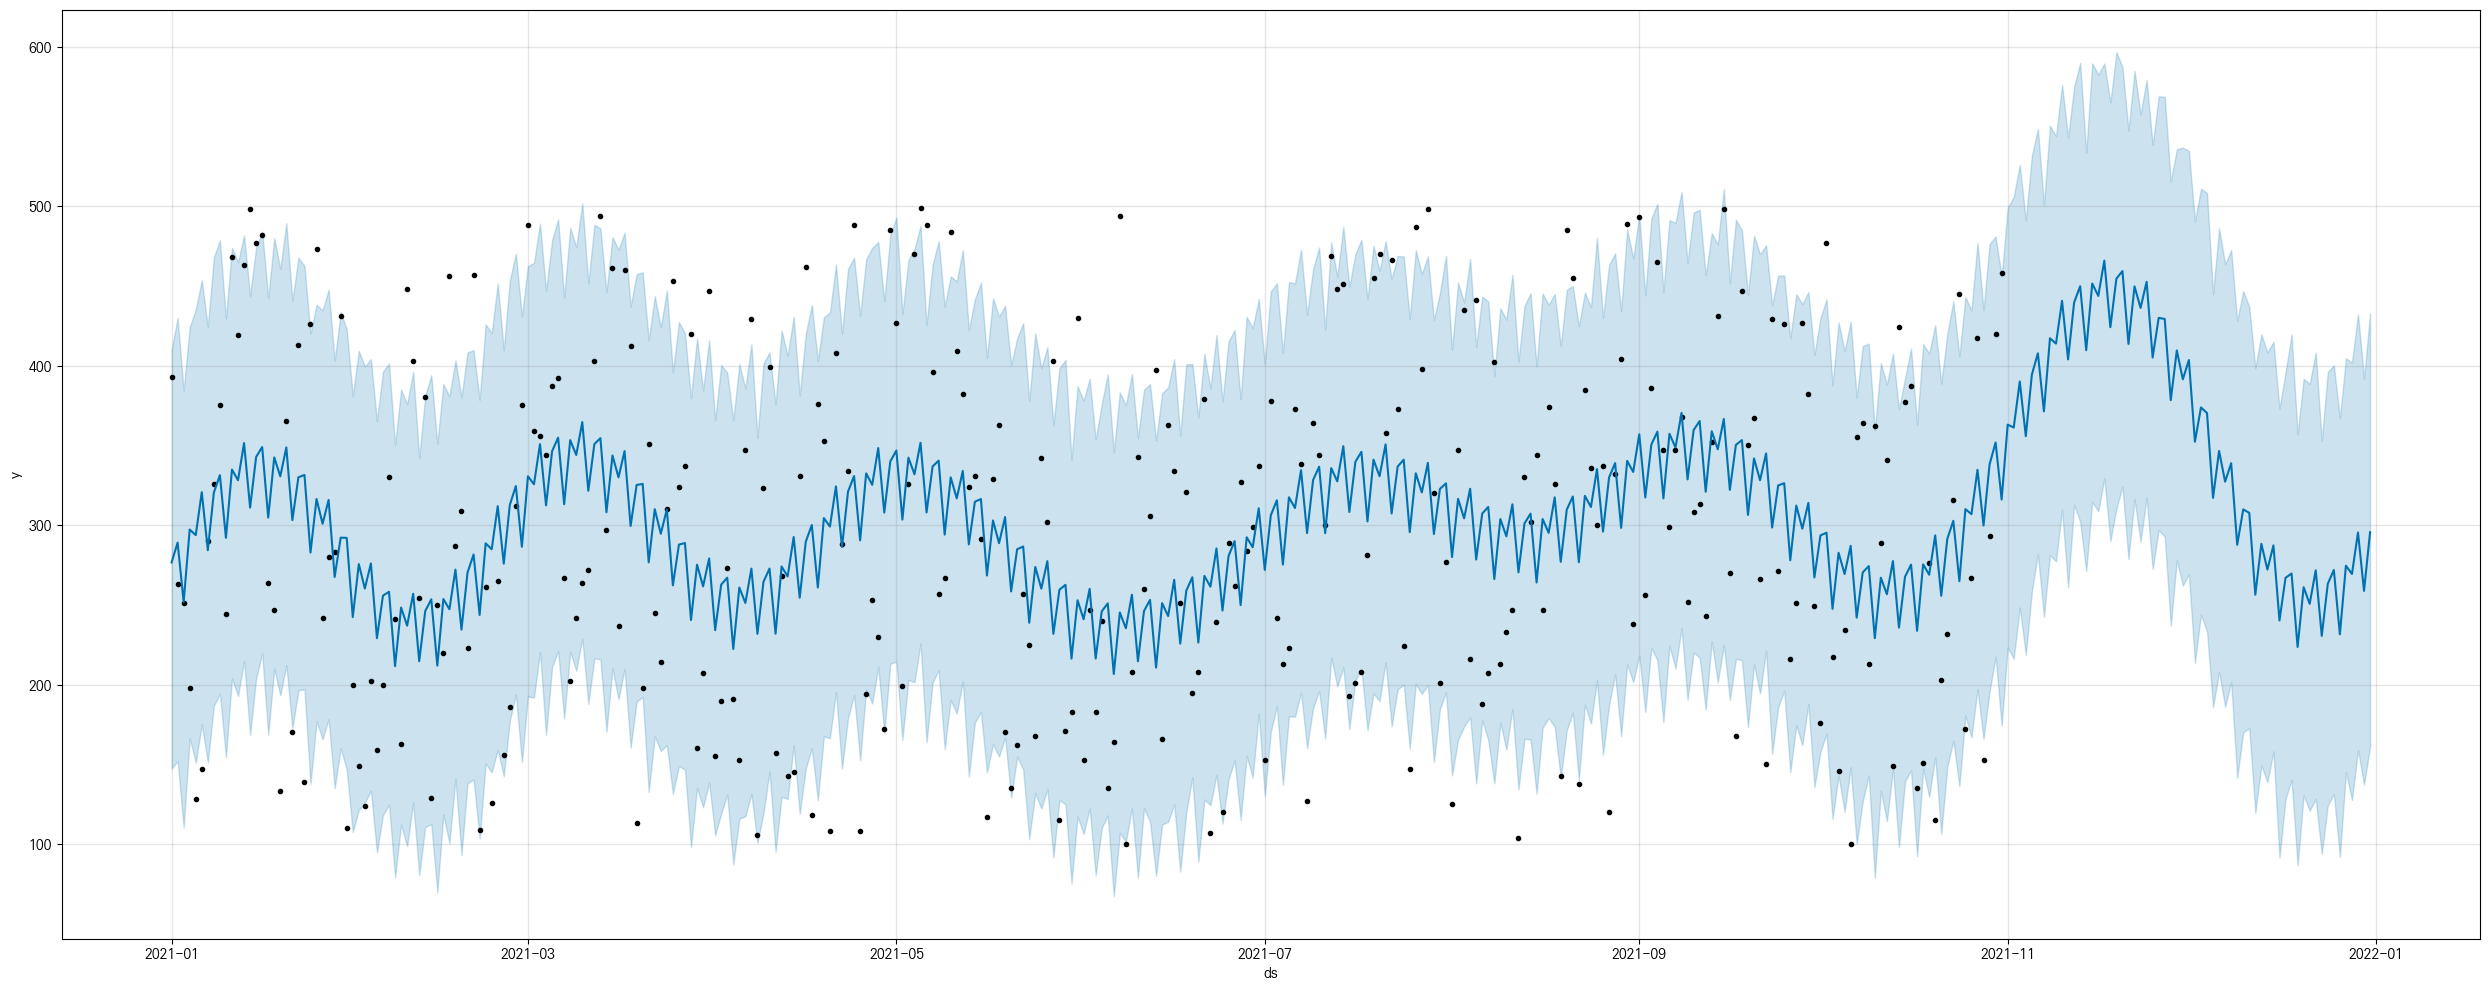

In [46]:
# Î™®Îç∏ ÏÉùÏÑ±
model = Prophet(
    changepoint_prior_scale=0.1,  # Ï∂îÏÑ∏ Î≥ÄÌôîÏ†ê ÎØºÍ∞êÎèÑ ÎÜíÏûÑ
    seasonality_prior_scale=10.0  # Í≥ÑÏ†àÏÑ± ÎØºÍ∞êÎèÑ ÎÜíÏûÑ
)

# Ïó∞Í∞Ñ Í≥ÑÏ†àÏÑ± Ï∂îÍ∞Ä (Í∏∞Î≥∏Ï†ÅÏúºÎ°ú ÌôúÏÑ±ÌôîÎê®)
model.add_seasonality(name='yearly', period=365.25, fourier_order=8)

# Î™®Îç∏ ÌïôÏäµ
model.fit(df)

# ÏòàÏ∏°Ìï† ÎØ∏Îûò ÎÇ†Ïßú ÏÉùÏÑ± (Ïó∞ÎßêÍπåÏßÄ ÌõÑ ÏòàÏ∏°)
future = model.make_future_dataframe(periods=61)

# ÏòàÏ∏°
forecast = model.predict(future)

# ÏòàÏ∏° Í≤∞Í≥º ÏãúÍ∞ÅÌôî
fig = model.plot(forecast, figsize=(25, 10))
plt.show()

- Ï∂îÏÑ∏ÏôÄ Í≥ÑÏ†àÏÑ± Ï°∞Ï†ïÏùò Ï§ëÏöîÏÑ±: **changepoint_prior_scale** ÏôÄ **seasonality_prior_scale** Îäî Î™®Îç∏Ïùò ÎØºÍ∞êÎèÑÎ•º Ï°∞Ï†àÌïòÏó¨ ÏòàÏ∏° Ï†ïÌôïÎèÑÎ•º Ìñ•ÏÉÅÏãúÌÇ¨ Ïàò ÏûàÏäµÎãàÎã§. Í∞íÏù¥ Ïª§ÏßÄÎ©¥ Î™®Îç∏ÏùÄ Ï∂îÏÑ∏ Î≥ÄÌôîÎÇò Í≥ÑÏ†àÏÑ±ÏùÑ Îçî ÎØºÍ∞êÌïòÍ≤å Î∞òÏòÅÌïòÍ≤å ÎêòÎ©∞, Ïù¥Îäî ÎπÑÏ¶àÎãàÏä§ÎÇò ÌòÑÏóÖÏóêÏÑú ÌäπÏ†ï ÏãúÍ∏∞ÎÇò Ïù¥Î≤§Ìä∏Ïóê ÎåÄÌïú ÏòàÏ∏°ÏùÑ Îçî Ï†ïÌôïÌïòÍ≤å ÎßåÎì≠ÎãàÎã§.

- Í≥ÑÏ†àÏÑ±Ïùò Ïª§Ïä§ÌÑ∞ÎßàÏù¥Ïßï: Ïó∞Í∞Ñ, ÏõîÍ∞Ñ, Ï£ºÍ∞Ñ Îì±Ïùò Í≥ÑÏ†àÏÑ±ÏùÄ Îç∞Ïù¥ÌÑ∞Ïóê ÎßûÍ≤å Ï°∞Ï†ïÌï† Ïàò ÏûàÏäµÎãàÎã§. ÏòàÎ•º Îì§Ïñ¥, ÌäπÏ†ï ÎπÑÏ¶àÎãàÏä§ÏóêÏÑú ÏõîÍ∞Ñ Í≥ÑÏ†àÏÑ±ÏùÑ Îçî Í∞ïÌïòÍ≤å Î∞òÏòÅÌï† ÌïÑÏöîÍ∞Ä ÏûàÎã§Î©¥ Fourier Ìä∏ÎûúÏä§ÌèºÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ Fourier orderÎ•º Ï°∞Ï†ïÌï† Ïàò ÏûàÏäµÎãàÎã§.

## üìå 3. Ìú¥Ïùº Ìö®Í≥º Î∞è Ïù¥Î≤§Ìä∏ Ï∂îÍ∞Ä

- **Ìú¥Ïùº(Holidays)** ÏùÄ ÏãúÍ≥ÑÏó¥ ÏòàÏ∏°Ïóê ÌÅ∞ ÏòÅÌñ•ÏùÑ ÎØ∏Ïπ† Ïàò ÏûàÏäµÎãàÎã§. ÏòàÎ•º Îì§Ïñ¥, ÌÅ¨Î¶¨Ïä§ÎßàÏä§, ÏÑ§ÎÇ†, Î∏îÎûô ÌîÑÎùºÏù¥Îç∞Ïù¥ÏôÄ Í∞ôÏùÄ ÌÅ∞ Ïù¥Î≤§Ìä∏Îäî ÏÜåÎπÑ Ìå®ÌÑ¥Ïóê ÌÅ∞ ÏòÅÌñ•ÏùÑ ÎØ∏Ïπ©ÎãàÎã§. 
- ProphetÏùÄ Ïù¥Îü¨Ìïú Ìú¥Ïùº Ìö®Í≥ºÎ•º ÏòàÏ∏° Î™®Îç∏Ïóê Î∞òÏòÅÌï† Ïàò ÏûàÏäµÎãàÎã§.
- ProphetÏóêÏÑúÎäî Ìú¥Ïùº Îç∞Ïù¥ÌÑ∞Î•º ÏûÖÎ†•Î∞õÏïÑ ÏòàÏ∏°Ïóê Î∞òÏòÅÌï©ÎãàÎã§. Ïù¥Î•º ÌÜµÌï¥ ÏòàÏ∏°Îêú ÎÇ†ÏßúÏóê ÎåÄÌïú Ï†ïÌôïÎèÑÎ•º Ìñ•ÏÉÅÏãúÌÇ¨ Ïàò ÏûàÏäµÎãàÎã§.

2025-04-04 15:35:40,176 - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2025-04-04 15:35:40,177 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2025-04-04 15:35:40,183 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/79hcps9u.json
2025-04-04 15:35:40,187 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/5mczi1rj.json
2025-04-04 15:35:40,188 - DEBUG - idx 0
2025-04-04 15:35:40,188 - DEBUG - running CmdStan, num_threads: None
2025-04-04 15:35:40,188 - DEBUG - CmdStan args: ['/usr/local/src/python3.10/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10778', 'data', 'file=/tmp/tmp1zhw1ynh/79hcps9u.json', 'init=/tmp/tmp1zhw1ynh/5mczi1rj.json', 'output', 'file=/tmp/tmp1zhw1ynh/prophet_modelazpzf288/prophet_model-20250404153540.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:35:40 - cmdstanpy - INFO - Chain [1] start processing
2025-04-04 15:35:40,188 - INFO - C

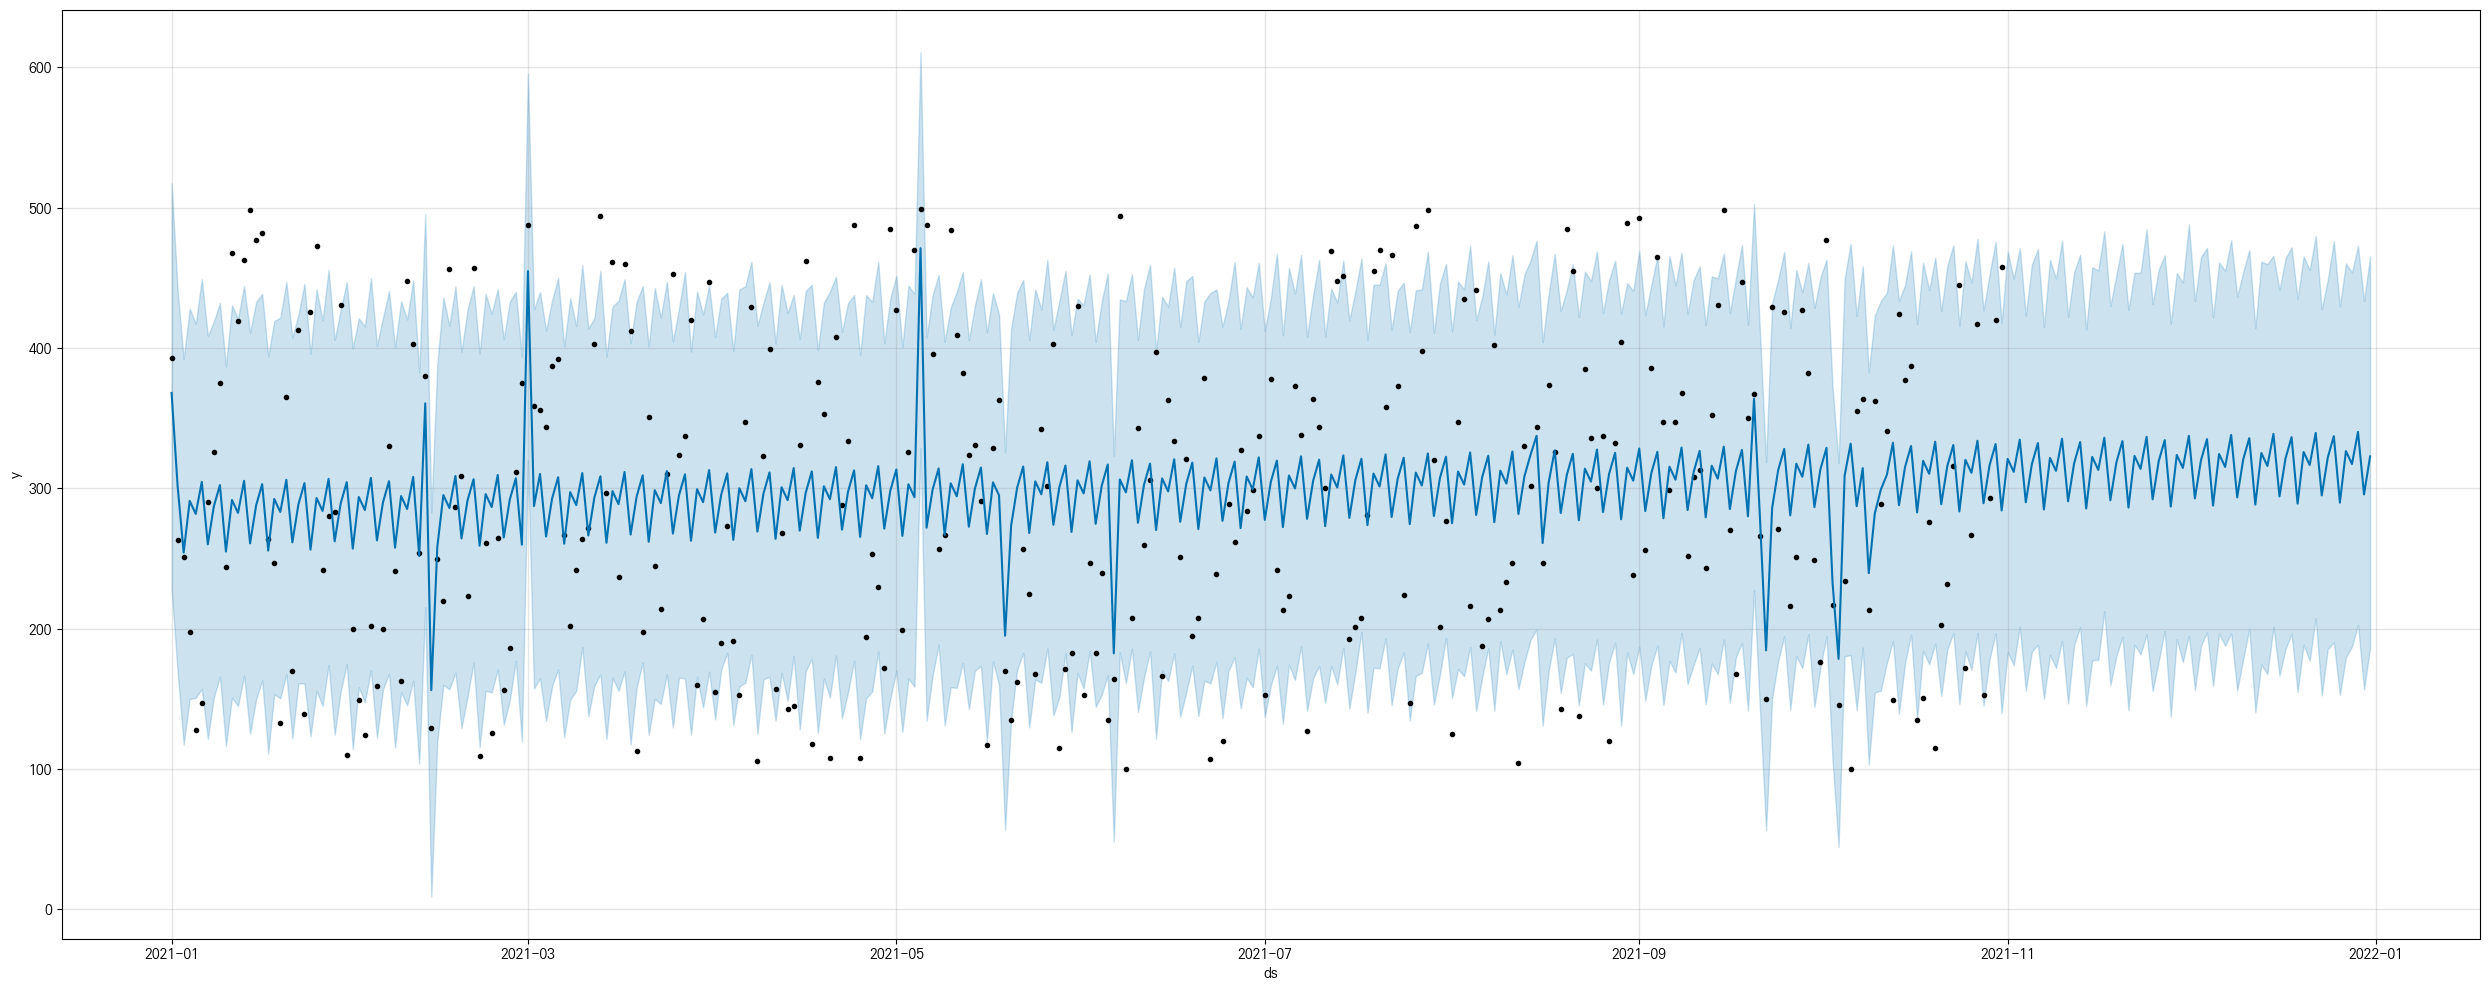

In [50]:
# Ìú¥Ïùº Îç∞Ïù¥ÌÑ∞ Ï∂îÍ∞Ä (Ïòà: ÌÅ¨Î¶¨Ïä§ÎßàÏä§ÏôÄ ÏÑ§ÎÇ†)
from prophet.make_holidays import make_holidays_df
holidays = make_holidays_df(year_list=[x for x in range(df['ds'].min().year, df['ds'].max().year+1)], country='KR')

# Î™®Îç∏ ÏÉùÏÑ± (Ìú¥Ïùº Îç∞Ïù¥ÌÑ∞ Ï∂îÍ∞Ä)
model = Prophet(holidays=holidays)

# Î™®Îç∏ ÌïôÏäµ
model.fit(df)

# ÏòàÏ∏°Ìï† ÎØ∏Îûò ÎÇ†Ïßú ÏÉùÏÑ± (30Ïùº ÌõÑ ÏòàÏ∏°)
future = model.make_future_dataframe(periods=61)

# ÏòàÏ∏°
forecast = model.predict(future)

# ÏòàÏ∏° Í≤∞Í≥º ÏãúÍ∞ÅÌôî
fig = model.plot(forecast, figsize=(25, 10))
plt.show()

## üìå 4. ÍµêÏ∞® Í≤ÄÏ¶ù (Cross-validation)Í≥º ÏÑ±Îä• ÌèâÍ∞Ä
- ÍµêÏ∞® Í≤ÄÏ¶ù (Cross-validation): ÍµêÏ∞® Í≤ÄÏ¶ùÏùÄ Î™®Îç∏Ïùò ÏÑ±Îä•ÏùÑ Í≤ÄÏ¶ùÌïòÎäî Ï§ëÏöîÌïú Î∞©Î≤ïÏûÖÎãàÎã§. ProphetÏóêÏÑúÎäî Ï£ºÏñ¥ÏßÑ ÏãúÍ≥ÑÏó¥ Îç∞Ïù¥ÌÑ∞Î•º Ïó¨Îü¨ Î∂ÄÎ∂ÑÏúºÎ°ú ÎÇòÎàÑÏñ¥, ÌïôÏäµÍ≥º Í≤ÄÏ¶ùÏùÑ Î∞òÎ≥µÌïòÎ©¥ÏÑú Î™®Îç∏Ïùò ÏÑ±Îä•ÏùÑ ÌèâÍ∞ÄÌï† Ïàò ÏûàÏäµÎãàÎã§. ProphetÏóêÏÑúÎäî ÏãúÍ≥ÑÏó¥ ÍµêÏ∞® Í≤ÄÏ¶ùÏùÑ ÏúÑÌï¥ prophet.diagnostics.cross_validation()ÏùÑ ÏÇ¨Ïö©Ìï©ÎãàÎã§.
- ÏÑ±Îä• ÌèâÍ∞Ä ÏßÄÌëú: ÏãúÍ≥ÑÏó¥ Î™®Îç∏ÏóêÏÑú ÏÑ±Îä• ÌèâÍ∞ÄÎ•º ÏúÑÌïú Ï£ºÏöî ÏßÄÌëúÎäî Ïó¨Îü¨ Í∞ÄÏßÄÍ∞Ä ÏûàÏäµÎãàÎã§. ProphetÏóêÏÑúÎäî MAE (Mean Absolute Error), MAPE (Mean Absolute Percentage Error), RMSE (Root Mean Squared Error) Îì±Ïùò ÏßÄÌëúÎ•º ÏÇ¨Ïö©ÌïòÏó¨ ÏòàÏ∏° ÏÑ±Îä•ÏùÑ ÌèâÍ∞ÄÌï©ÎãàÎã§.
    - MAE (Mean Absolute Error): ÏòàÏ∏°Í∞íÍ≥º Ïã§Ï†úÍ∞í Í∞ÑÏùò Ï†àÎåÄÏ†Å Ï∞®Ïù¥Ïùò ÌèâÍ∑†
    - MAPE (Mean Absolute Percentage Error): ÏòàÏ∏°Í∞íÍ≥º Ïã§Ï†úÍ∞í Í∞ÑÏùò Î∞±Î∂ÑÏú® Ï∞®Ïù¥Ïùò ÌèâÍ∑†
    - RMSE (Root Mean Squared Error): ÏòàÏ∏°Í∞íÍ≥º Ïã§Ï†úÍ∞í Í∞ÑÏùò Ï∞®Ïù¥Ïùò Ï†úÍ≥± ÌèâÍ∑†ÏùÑ Íµ¨ÌïòÍ≥† Í∑∏ Ï†úÍ≥±Í∑ºÏùÑ Ï∑®Ìïú Í∞íÏúºÎ°ú, ÏòàÏ∏° Ïò§Ï∞®Ïùò ÌÅ¨Í∏∞Î•º Ï†ïÎüâÌôîÌï©ÎãàÎã§.

In [51]:
from prophet.diagnostics import cross_validation, performance_metrics

# Prophet Î™®Îç∏ ÏÉùÏÑ±
model = Prophet()

# Î™®Îç∏ ÌïôÏäµ
model.fit(df)

# ÍµêÏ∞® Í≤ÄÏ¶ù Ïã§Ìñâ (Ï¥àÍ∏∞ 180Ïùº ÌïôÏäµ ÌõÑ 30Ïùº Í∞ÑÍ≤©ÏúºÎ°ú ÏòàÏ∏°)
df_cv = cross_validation(model, initial='180 days', period='30 days', horizon='60 days')

# ÏÑ±Îä• ÏßÄÌëú Í≥ÑÏÇ∞
df_p = performance_metrics(df_cv)

# ÏÑ±Îä• ÏßÄÌëú Ï∂úÎ†•
print(df_p)

2025-04-04 15:42:04,896 - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2025-04-04 15:42:04,896 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2025-04-04 15:42:04,900 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/tjdrpv8s.json
2025-04-04 15:42:04,903 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/4k0k41te.json
2025-04-04 15:42:04,903 - DEBUG - idx 0
2025-04-04 15:42:04,903 - DEBUG - running CmdStan, num_threads: None
2025-04-04 15:42:04,903 - DEBUG - CmdStan args: ['/usr/local/src/python3.10/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16421', 'data', 'file=/tmp/tmp1zhw1ynh/tjdrpv8s.json', 'init=/tmp/tmp1zhw1ynh/4k0k41te.json', 'output', 'file=/tmp/tmp1zhw1ynh/prophet_modele3twbz4m/prophet_model-20250404154204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:42:04 - cmdstanpy - INFO - Chain [1] start processing
2025-04-04 15:42:04,903 - INFO - C

  0%|          | 0/3 [00:00<?, ?it/s]

2025-04-04 15:42:04,918 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/lesrn7nr.json
2025-04-04 15:42:04,919 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/vwyblwrr.json
2025-04-04 15:42:04,920 - DEBUG - idx 0
2025-04-04 15:42:04,920 - DEBUG - running CmdStan, num_threads: None
2025-04-04 15:42:04,920 - DEBUG - CmdStan args: ['/usr/local/src/python3.10/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55477', 'data', 'file=/tmp/tmp1zhw1ynh/lesrn7nr.json', 'init=/tmp/tmp1zhw1ynh/vwyblwrr.json', 'output', 'file=/tmp/tmp1zhw1ynh/prophet_model3k9iis9s/prophet_model-20250404154204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:42:04 - cmdstanpy - INFO - Chain [1] start processing
2025-04-04 15:42:04,920 - INFO - Chain [1] start processing
15:42:04 - cmdstanpy - INFO - Chain [1] done processing
2025-04-04 15:42:04,924 - INFO - Chain [1] done processing
2025-04-04 15:42:04,946 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/219r8915.json
2025-04-04 15:42:04,

   horizon           mse        rmse         mae      mape     mdape  \
0   6 days  10690.707554  103.395878   91.159862  0.319474  0.300246   
1   7 days  10151.406654  100.754189   90.700353  0.328842  0.300246   
2   8 days   9497.729299   97.456294   85.876142  0.307580  0.216345   
3   9 days   7874.154512   88.736433   75.988468  0.290229  0.210372   
4  10 days  10485.333746  102.397919   83.607628  0.350304  0.210372   
5  11 days  10645.456278  103.176820   82.008918  0.297619  0.205189   
6  12 days   9156.604906   95.690151   72.578325  0.282403  0.205189   
7  13 days  10234.045629  101.163460   79.366255  0.299319  0.249277   
8  14 days  11663.474881  107.997569   87.284955  0.318138  0.298499   
9  15 days   9939.059091   99.694830   80.230251  0.301751  0.274113   
10 16 days   9186.718348   95.847370   77.908842  0.260269  0.274113   
11 17 days  12624.854117  112.360376   93.963006  0.324511  0.298499   
12 18 days  14696.015266  121.227123  106.252591  0.343430  0.29

- cross_validation(): initial, period, horizon ÌååÎùºÎØ∏ÌÑ∞Î•º ÏÇ¨Ïö©ÌïòÏó¨ ÍµêÏ∞® Í≤ÄÏ¶ùÏùÑ Ïã§ÌñâÌï©ÎãàÎã§.
    - initial: ÌïôÏäµ Îç∞Ïù¥ÌÑ∞Ïùò Ï¥àÍ∏∞ Í∏∞Í∞ÑÏùÑ ÏÑ§Ï†ïÌï©ÎãàÎã§. ÏòàÎ•º Îì§Ïñ¥, '180 days'Îäî ÌïôÏäµ Îç∞Ïù¥ÌÑ∞Î°ú 180ÏùºÏùÑ ÏÇ¨Ïö©ÌïòÍ≤†Îã§Îäî ÏùòÎØ∏ÏûÖÎãàÎã§.
    - period: ÏòàÏ∏°ÏùÑ ÌèâÍ∞ÄÌï† Í∞ÑÍ≤©ÏùÑ ÏÑ§Ï†ïÌï©ÎãàÎã§. ÏòàÎ•º Îì§Ïñ¥, '30 days'Îäî 30ÏùºÎßàÎã§ ÏòàÏ∏°ÏùÑ ÌèâÍ∞ÄÌï©ÎãàÎã§.
    - horizon: ÏòàÏ∏°Ïùò Í∏∞Í∞ÑÏùÑ ÏÑ§Ï†ïÌï©ÎãàÎã§. ÏòàÎ•º Îì§Ïñ¥, '60 days'Îäî 60Ïùº ÎèôÏïàÏùò ÏòàÏ∏°ÏùÑ ÌèâÍ∞ÄÌï©ÎãàÎã§.
- performance_metrics(): ÍµêÏ∞® Í≤ÄÏ¶ù Í≤∞Í≥ºÏóê ÎåÄÌïú ÏÑ±Îä• ÏßÄÌëúÎ•º Í≥ÑÏÇ∞Ìï©ÎãàÎã§. MAE, MAPE, RMSE Îì± Îã§ÏñëÌïú ÏßÄÌëúÎ•º Ï†úÍ≥µÌïòÏó¨ Î™®Îç∏Ïùò ÏÑ±Îä•ÏùÑ ÌèâÍ∞ÄÌï©ÎãàÎã§.

- ÍµêÏ∞® Í≤ÄÏ¶ùÏùò ÌïÑÏöîÏÑ±: ÏãúÍ≥ÑÏó¥ Î™®Îç∏ÏóêÏÑúÎäî Í≥ºÏ†ÅÌï©ÏùÑ Î∞©ÏßÄÌïòÎäî Í≤ÉÏù¥ Ï§ëÏöîÌï©ÎãàÎã§. Í≥ºÏ†ÅÌï©Ïù¥ÎûÄ, Î™®Îç∏Ïù¥ ÌõàÎ†® Îç∞Ïù¥ÌÑ∞Ïóê ÎÑàÎ¨¥ Ïûò ÎßûÏ∂∞Ï†∏ÏÑú ÏÉàÎ°úÏö¥ Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌïú ÏòàÏ∏° ÏÑ±Îä•Ïù¥ Îñ®Ïñ¥ÏßÄÎäî ÌòÑÏÉÅÏûÖÎãàÎã§. ÍµêÏ∞® Í≤ÄÏ¶ùÏùÄ Î™®Îç∏Ïù¥ ÏÉàÎ°úÏö¥ Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌï¥ÏÑúÎèÑ Ïûò ÏòàÏ∏°Ìï† Ïàò ÏûàÎäîÏßÄÎ•º ÌôïÏù∏ÌïòÎäî Ï§ëÏöîÌïú Î∞©Î≤ïÏûÖÎãàÎã§.

- ÏÑ±Îä• ÌèâÍ∞Ä ÏßÄÌëúÏùò Ìï¥ÏÑù:
    - MAE: ÏòàÏ∏°Í∞íÍ≥º Ïã§Ï†úÍ∞íÏùò Ï∞®Ïù¥Î•º Ï†àÎåÄÍ∞íÏúºÎ°ú Í≥ÑÏÇ∞ÌïòÏó¨ ÌèâÍ∑†ÏùÑ ÎÇ∏ Í≤ÉÏûÖÎãàÎã§. ÎÇÆÏùÑÏàòÎ°ù ÏòàÏ∏°Ïù¥ Ï†ïÌôïÌïòÎã§Îäî ÏùòÎØ∏ÏûÖÎãàÎã§.
    - MAPE: Î∞±Î∂ÑÏú®Î°ú Í≥ÑÏÇ∞Îêú Ïò§Ï∞® ÌèâÍ∑†ÏûÖÎãàÎã§. ÏòàÏ∏° Ï†ïÌôïÎèÑÍ∞Ä Ï¢ãÏúºÎ©¥ MAPEÍ∞Ä ÎÇÆÏäµÎãàÎã§.
    - RMSE: ÏòàÏ∏° Ïò§Ï∞®Ïùò Ï†úÍ≥± ÌèâÍ∑†Ïùò Ï†úÍ≥±Í∑ºÏúºÎ°ú, ÏòàÏ∏°Í∞íÍ≥º Ïã§Ï†úÍ∞íÏùò Ï∞®Ïù¥Î•º Ï†úÍ≥±ÌïòÏó¨ ÌèâÍ∑†Ìïú Îí§, Í∑∏ Í∞íÏùÑ Ï†úÍ≥±Í∑ºÏúºÎ°ú Î≥ÄÌôòÌïú Í∞íÏûÖÎãàÎã§. ÎÇÆÏùÑÏàòÎ°ù Î™®Îç∏Ïù¥ Ï†ïÌôïÌïòÎã§Îäî ÏùòÎØ∏ÏûÖÎãàÎã§.

## üìå 5. Í≥†Í∏â ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÌäúÎãù

- ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ (Hyperparameters): ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞Îäî Î™®Îç∏Ïùò ÏÑ±Îä•Ïóê ÌÅ∞ ÏòÅÌñ•ÏùÑ ÎØ∏ÏπòÎäî Î≥ÄÏàòÎ°ú, ÏòàÎ•º Îì§Ïñ¥ Ï∂îÏÑ∏ Î≥ÄÌôîÏ†ê ÎØºÍ∞êÎèÑ, Í≥ÑÏ†àÏÑ± ÎØºÍ∞êÎèÑ, Ìú¥Ïùº ÎØºÍ∞êÎèÑ Îì±Ïù¥ ÏûàÏäµÎãàÎã§. ProphetÏóêÏÑú Ï§ëÏöîÌïú ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞Î°úÎäî changepoint_prior_scale, seasonality_prior_scale, holidays_prior_scale Îì±Ïù¥ ÏûàÏäµÎãàÎã§.
- changepoint_prior_scale: Ï∂îÏÑ∏ Î≥ÄÌôîÏ†êÏùò ÎØºÍ∞êÎèÑÎ•º ÏÑ§Ï†ïÌïòÎäî ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ÏûÖÎãàÎã§. Í∞íÏù¥ ÌÅ¨Î©¥ ProphetÏùÄ Îçî ÏûêÏ£º Ï∂îÏÑ∏ Î≥ÄÌôîÏ†êÏùÑ Í∞êÏßÄÌïòÎ†§Í≥† ÏãúÎèÑÌï©ÎãàÎã§.
- seasonality_prior_scale: Í≥ÑÏ†àÏÑ±Ïùò ÎØºÍ∞êÎèÑÎ•º ÏÑ§Ï†ïÌïòÎäî ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ÏûÖÎãàÎã§. Í∞íÏù¥ ÌÅ¨Î©¥ ProphetÏùÄ Í≥ÑÏ†àÏÑ± Ìå®ÌÑ¥ÏùÑ Îçî Í∞ïÌïòÍ≤å Î∞òÏòÅÌïòÎ†§Í≥† Ìï©ÎãàÎã§.
- holidays_prior_scale: Ìú¥Ïùº Ìö®Í≥ºÏùò ÎØºÍ∞êÎèÑÎ•º ÏÑ§Ï†ïÌïòÎäî ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ÏûÖÎãàÎã§. Í∞íÏù¥ ÌÅ¨Î©¥ Ìú¥Ïùº Ìö®Í≥ºÎ•º Îçî Í∞ïÌïòÍ≤å Î∞òÏòÅÌïòÎ†§Í≥† Ìï©ÎãàÎã§.

2025-04-04 15:45:44,584 - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2025-04-04 15:45:44,584 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2025-04-04 15:45:44,588 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/ft7_ncdt.json
2025-04-04 15:45:44,591 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/97yw5yra.json
2025-04-04 15:45:44,591 - DEBUG - idx 0
2025-04-04 15:45:44,591 - DEBUG - running CmdStan, num_threads: None
2025-04-04 15:45:44,591 - DEBUG - CmdStan args: ['/usr/local/src/python3.10/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85746', 'data', 'file=/tmp/tmp1zhw1ynh/ft7_ncdt.json', 'init=/tmp/tmp1zhw1ynh/97yw5yra.json', 'output', 'file=/tmp/tmp1zhw1ynh/prophet_modelpxz18qwd/prophet_model-20250404154544.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:45:44 - cmdstanpy - INFO - Chain [1] start processing
2025-04-04 15:45:44,591 - INFO - C

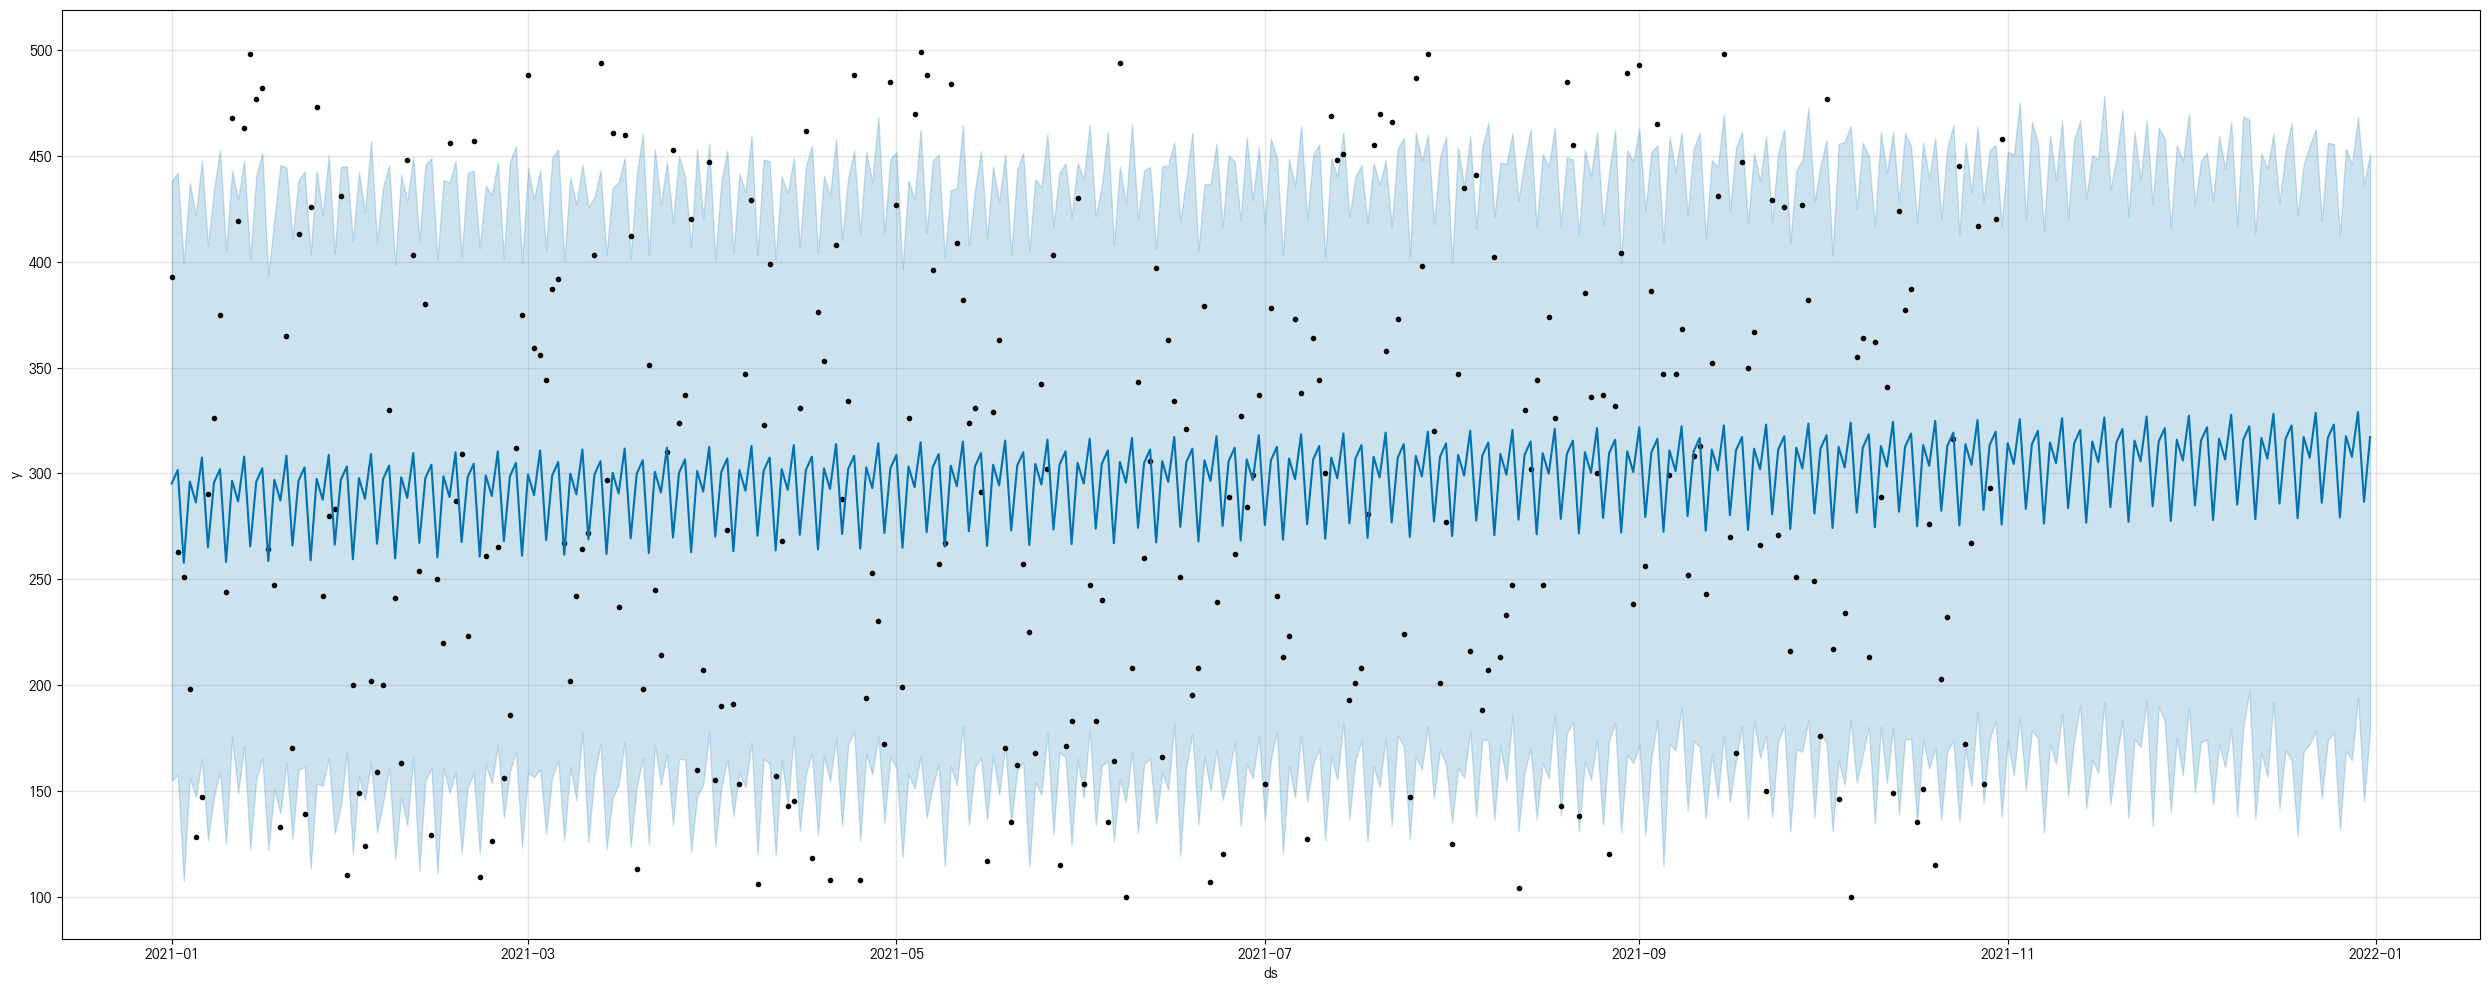

In [57]:
# ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÌäúÎãù (changepoint_prior_scale, seasonality_prior_scale Ï°∞Ï†ï)
model = Prophet(
    changepoint_prior_scale=0.1,  # Ï∂îÏÑ∏ Î≥ÄÌôîÏ†ê ÎØºÍ∞êÎèÑ ÎÜíÏûÑ
    seasonality_prior_scale=20.0  # Í≥ÑÏ†àÏÑ± ÎØºÍ∞êÎèÑ ÎÜíÏûÑ
)

# Î™®Îç∏ ÌïôÏäµ
model.fit(df)

# ÏòàÏ∏°Ìï† ÎØ∏Îûò ÎÇ†Ïßú ÏÉùÏÑ± (Ïó∞ÎßêÍπåÏßÄ ÏòàÏ∏°)
future = model.make_future_dataframe(periods=61)

# ÏòàÏ∏°
forecast = model.predict(future)

# ÏòàÏ∏° Í≤∞Í≥º ÏãúÍ∞ÅÌôî
fig = model.plot(forecast, figsize=(25, 10))
plt.show()

- changepoint_prior_scaleÏôÄ seasonality_prior_scaleÎ•º Ï°∞Ï†ïÌïòÏó¨ Ï∂îÏÑ∏ÏôÄ Í≥ÑÏ†àÏÑ±Ïùò ÎØºÍ∞êÎèÑÎ•º ÎÜíÏòÄÏäµÎãàÎã§. Ïù¥Î†áÍ≤å ÌïòÏó¨ Ï∂îÏÑ∏ Î≥ÄÌôîÏ†êÍ≥º Í≥ÑÏ†àÏÑ± Ìå®ÌÑ¥Ïù¥ Î™®Îç∏Ïóê Îçî ÎßéÏù¥ Î∞òÏòÅÎêòÎèÑÎ°ù ÏÑ§Ï†ïÌñàÏäµÎãàÎã§.
- ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÌäúÎãùÏùò Ï§ëÏöîÏÑ±: Î™®Îç∏Ïùò ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞Î•º Ï†ÅÏ†àÌûà ÌäúÎãùÌïòÎäî Í≤ÉÏù¥ ÏòàÏ∏° ÏÑ±Îä•Ïóê ÌÅ∞ ÏòÅÌñ•ÏùÑ ÎØ∏Ïπ©ÎãàÎã§. ÏòàÎ•º Îì§Ïñ¥, Ï∂îÏÑ∏ Î≥ÄÌôîÏ†ê Í∞êÏßÄ ÎØºÍ∞êÎèÑÎ•º ÎÑàÎ¨¥ ÎÜíÍ≤å ÏÑ§Ï†ïÌïòÎ©¥, Î™®Îç∏Ïù¥ ÎÑàÎ¨¥ ÎßéÏùÄ Î≥ÄÌôîÎ•º Í∞êÏßÄÌïòÏó¨ Í≥ºÏ†ÅÌï©Ïù¥ Î∞úÏÉùÌï† Ïàò ÏûàÏäµÎãàÎã§. Î∞òÎåÄÎ°ú ÎÑàÎ¨¥ ÎÇÆÍ≤å ÏÑ§Ï†ïÌïòÎ©¥ Ï§ëÏöîÌïú Î≥ÄÌôîÏ†êÏùÑ ÎÜìÏπ† Ïàò ÏûàÏäµÎãàÎã§.
- ÌäúÎãù Î∞©Î≤ï: ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞Î•º Ï°∞Ï†ïÌï† ÎïåÎäî ÍµêÏ∞® Í≤ÄÏ¶ùÏùÑ ÌÜµÌï¥ ÏÑ±Îä•ÏùÑ ÌèâÍ∞ÄÌïòÍ≥†, Í∞ÄÏû• Ï†ÅÌï©Ìïú Í∞íÏùÑ Ï∞æÏïÑÏïº Ìï©ÎãàÎã§. Ïù¥Î•º ÌÜµÌï¥ Î™®Îç∏ÏùÑ ÏµúÏ†ÅÌôîÌï† Ïàò ÏûàÏäµÎãàÎã§.



## üìå 6. ÎåÄÍ∑úÎ™® ÏãúÍ≥ÑÏó¥ Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨ Î∞è ÏÑ±Îä• ÏµúÏ†ÅÌôî
- ÎåÄÍ∑úÎ™® Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨: ProphetÏùÄ ÎåÄÍ∑úÎ™® ÏãúÍ≥ÑÏó¥ Îç∞Ïù¥ÌÑ∞ÎèÑ Ï≤òÎ¶¨Ìï† Ïàò ÏûàÏßÄÎßå, Îç∞Ïù¥ÌÑ∞Í∞Ä Ïª§ÏßàÏàòÎ°ù Î™®Îç∏ ÌïôÏäµ ÏãúÍ∞ÑÍ≥º ÏòàÏ∏° ÏãúÍ∞ÑÏù¥ Í∏∏Ïñ¥Ïßà Ïàò ÏûàÏäµÎãàÎã§. Ïù¥Îïå ÏÑ±Îä• ÏµúÏ†ÅÌôîÎ•º ÌÜµÌï¥ Îπ†Î•¥Í≥† Ìö®Ïú®Ï†ÅÏù∏ ÏòàÏ∏°ÏùÑ Ìï† Ïàò ÏûàÏäµÎãàÎã§.
- ÏÑ±Îä• ÏµúÏ†ÅÌôî Î∞©Î≤ï:
    - Î≥ëÎ†¨ Ï≤òÎ¶¨: Îç∞Ïù¥ÌÑ∞Í∞Ä Îß§Ïö∞ ÌÅ¨Î©¥, ProphetÏùÄ ÎÇ¥Î∂ÄÏ†ÅÏúºÎ°ú Î≥ëÎ†¨ Ï≤òÎ¶¨Î•º ÌÜµÌï¥ ÏòàÏ∏° ÏÑ±Îä•ÏùÑ Ìñ•ÏÉÅÏãúÌÇ¨ Ïàò ÏûàÏäµÎãàÎã§.
    - ÏÉòÌîåÎßÅ: Îç∞Ïù¥ÌÑ∞ ÏÉòÌîåÎßÅÏùÑ ÌÜµÌï¥ Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞Î•º Îã§ ÏÇ¨Ïö©ÌïòÏßÄ ÏïäÍ≥† ÏùºÎ∂Ä ÏÉòÌîå Îç∞Ïù¥ÌÑ∞Î•º ÏÇ¨Ïö©ÌïòÏó¨ Prophet Î™®Îç∏ÏùÑ ÌïôÏäµÏãúÌÇ¨ Ïàò ÏûàÏäµÎãàÎã§.

2025-04-04 15:54:17,175 - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2025-04-04 15:54:17,176 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2025-04-04 15:54:17,180 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/812q0xz_.json
2025-04-04 15:54:17,182 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/0n1jpaav.json
2025-04-04 15:54:17,182 - DEBUG - idx 0
2025-04-04 15:54:17,183 - DEBUG - running CmdStan, num_threads: None
2025-04-04 15:54:17,183 - DEBUG - CmdStan args: ['/usr/local/src/python3.10/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25848', 'data', 'file=/tmp/tmp1zhw1ynh/812q0xz_.json', 'init=/tmp/tmp1zhw1ynh/0n1jpaav.json', 'output', 'file=/tmp/tmp1zhw1ynh/prophet_modelc3rcnxx1/prophet_model-20250404155417.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:54:17 - cmdstanpy - INFO - Chain [1] start processing
2025-04-04 15:54:17,183 - INFO - C

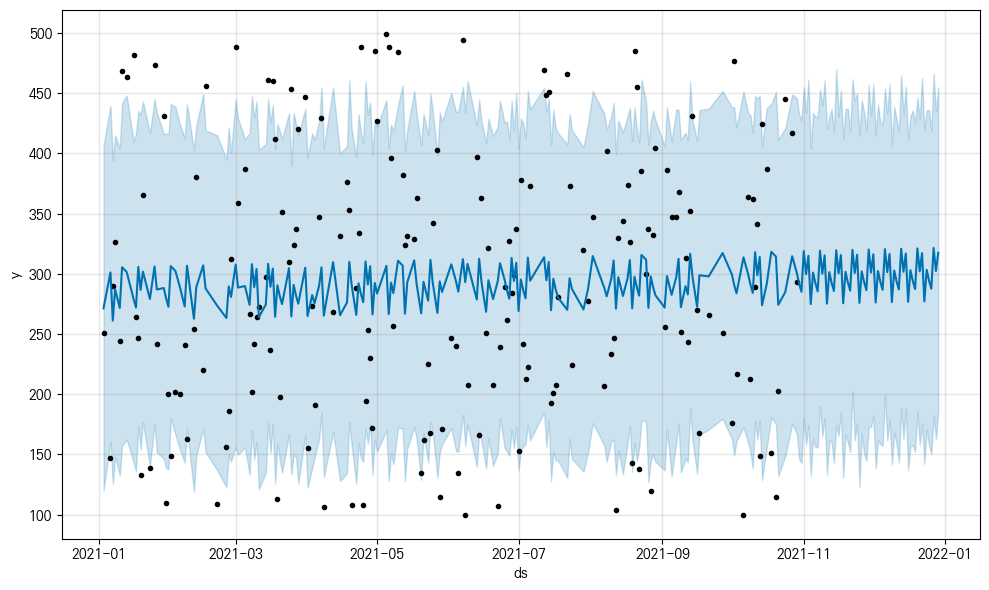

In [63]:
# Îç∞Ïù¥ÌÑ∞ ÏÉòÌîåÎßÅ
df_sampled = df.sample(frac=0.6, random_state=42)  # 10% ÏÉòÌîåÎßÅ

# Î™®Îç∏ ÌïôÏäµ (ÏÉòÌîå Îç∞Ïù¥ÌÑ∞Î°ú)
model = Prophet()
model.fit(df_sampled)

# ÏòàÏ∏°Ìï† ÎØ∏Îûò ÎÇ†Ïßú ÏÉùÏÑ± (30Ïùº ÌõÑ ÏòàÏ∏°)
future = model.make_future_dataframe(periods=61)

# ÏòàÏ∏°
forecast = model.predict(future)

# ÏòàÏ∏° Í≤∞Í≥º ÏãúÍ∞ÅÌôî
fig = model.plot(forecast)
plt.show()

# Prophet Î™®Îç∏ ÏÉùÏÑ± Ïãú Ï£ºÏöî ÌååÎùºÎØ∏ÌÑ∞
Prophet() Î™®Îç∏ÏùÑ ÏÉùÏÑ±Ìï† Îïå ÏÇ¨Ïö©Ìï† Ïàò ÏûàÎäî Ïó¨Îü¨ Í∞ÄÏßÄ ÌååÎùºÎØ∏ÌÑ∞Í∞Ä ÏûàÏäµÎãàÎã§. Í∞Å ÌååÎùºÎØ∏ÌÑ∞Îäî Î™®Îç∏Ïùò ÏÑ±Í≤©Í≥º ÏòàÏ∏°ÏùÑ Ïñ¥ÎñªÍ≤å Îã§Î£∞ÏßÄÏóê ÌÅ∞ ÏòÅÌñ•ÏùÑ ÎØ∏Ïπ©ÎãàÎã§.

## 1. growth
- ÏÑ§Î™Ö: growthÎäî Îç∞Ïù¥ÌÑ∞Ïùò Ï∂îÏÑ∏Í∞Ä ÏÑ†ÌòïÏù∏ÏßÄ Î°úÏßÄÏä§Ìã±Ïù∏ÏßÄÎ•º Í≤∞Ï†ïÌï©ÎãàÎã§.
- Í∞ÄÎä•Ìïú Í∞í:
    - 'linear': Í∏∞Î≥∏Í∞í. ÏÑ†Ìòï Ï∂îÏÑ∏Î•º ÏÇ¨Ïö©Ìï©ÎãàÎã§.
    - 'logistic': Î°úÏßÄÏä§Ìã± ÏÑ±Ïû•ÏùÑ ÏÇ¨Ïö©Ìï©ÎãàÎã§. Ï£ºÎ°ú Ï†úÌïúÎêú ÏûêÏõê(Ïòà: Ïù∏Íµ¨ Ïàò, ÌåêÎß§ ÏàòÎüâ Îì±)Ïóê ÎåÄÌï¥ ÏòàÏ∏°Ìï† Îïå ÏÇ¨Ïö©Îê©ÎãàÎã§.
```model = Prophet(growth='logistic')```

## 2. changepoint_prior_scale
- ÏÑ§Î™Ö: Ïù¥ ÌååÎùºÎØ∏ÌÑ∞Îäî Ï∂îÏÑ∏ Î≥ÄÌôîÏ†ê(changepoint)Ïùò ÎØºÍ∞êÎèÑÎ•º ÏÑ§Ï†ïÌï©ÎãàÎã§. Ï∂îÏÑ∏ Î≥ÄÌôîÏ†êÏùÄ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Ï∂îÏÑ∏Í∞Ä Í∏âÍ≤©ÌïòÍ≤å Î≥ÄÌôîÌïòÎäî ÏßÄÏ†êÏùÑ Ï∞æÎäî Îç∞ ÏÇ¨Ïö©Îê©ÎãàÎã§.
    - Í∞íÏù¥ ÌÅ¨Î©¥: ProphetÏùÄ Îçî ÏûêÏ£º Ï∂îÏÑ∏ Î≥ÄÌôîÏ†êÏùÑ Í∞êÏßÄÌïòÎ†§Í≥† ÏãúÎèÑÌï©ÎãàÎã§.
    - Í∞íÏù¥ ÏûëÏúºÎ©¥: Î≥ÄÌôîÏ†êÏùÑ Îçú ÎØºÍ∞êÌïòÍ≤å Í∞êÏßÄÌïòÍ≥†, Ï∂îÏÑ∏Î•º Îçî Î∂ÄÎìúÎüΩÍ≤å Î™®Îç∏ÎßÅÌï©ÎãàÎã§.
- Í∏∞Î≥∏Í∞í: 0.05
```model = Prophet(changepoint_prior_scale=0.1)```

## 3. changepoint_range
- ÏÑ§Î™Ö: Ï∂îÏÑ∏ Î≥ÄÌôîÏ†êÏùÑ ÌÉêÏßÄÌï† Ïàò ÏûàÎäî Îç∞Ïù¥ÌÑ∞Ïùò ÎπÑÏú®ÏùÑ ÏÑ§Ï†ïÌï©ÎãàÎã§. 0ÏóêÏÑú 1 ÏÇ¨Ïù¥Ïùò Í∞íÏúºÎ°ú ÏÑ§Ï†ïÌï† Ïàò ÏûàÏúºÎ©∞, 1ÏùÄ Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Ï∂îÏÑ∏ Î≥ÄÌôîÏ†êÏùÑ Í∞êÏßÄÌïòÎ†§Îäî Î≤îÏúÑÎ•º ÏùòÎØ∏Ìï©ÎãàÎã§.
- Í∏∞Î≥∏Í∞í: 0.8 (80%Ïùò Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Î≥ÄÌôîÏ†ê ÌÉêÏßÄ)

```model = Prophet(changepoint_range=0.9)```

## 4. yearly_seasonality
- ÏÑ§Î™Ö: Ïó∞Í∞Ñ Í≥ÑÏ†àÏÑ±ÏùÑ Î™®Îç∏Ïóê Ï∂îÍ∞ÄÌï†ÏßÄ Ïó¨Î∂ÄÎ•º ÏÑ§Ï†ïÌï©ÎãàÎã§.
- Í∞ÄÎä•Ìïú Í∞í:
    - True (Í∏∞Î≥∏Í∞í): Ïó∞Í∞Ñ Í≥ÑÏ†àÏÑ±ÏùÑ ÏÇ¨Ïö©Ìï©ÎãàÎã§.
    - False: Ïó∞Í∞Ñ Í≥ÑÏ†àÏÑ±ÏùÑ ÏÇ¨Ïö©ÌïòÏßÄ ÏïäÏäµÎãàÎã§.
    - int ÎòêÎäî list: ÏÇ¨Ïö©Ïûê Ï†ïÏùò Fourier Ìï≠ ÏàòÎ•º ÏÑ§Ï†ïÌï† Ïàò ÏûàÏäµÎãàÎã§. fourier_orderÏôÄ Í≤∞Ìï©Ìï¥ÏÑú ÏÇ¨Ïö©Ìï† Ïàò ÏûàÏäµÎãàÎã§.
```model = Prophet(yearly_seasonality=True)```

## 5. weekly_seasonality
- ÏÑ§Î™Ö: Ï£ºÍ∞Ñ Í≥ÑÏ†àÏÑ±ÏùÑ Î™®Îç∏Ïóê Ï∂îÍ∞ÄÌï†ÏßÄ Ïó¨Î∂ÄÎ•º ÏÑ§Ï†ïÌï©ÎãàÎã§.
- Í∞ÄÎä•Ìïú Í∞í:
    - True (Í∏∞Î≥∏Í∞í): Ï£ºÍ∞Ñ Í≥ÑÏ†àÏÑ±ÏùÑ ÏÇ¨Ïö©Ìï©ÎãàÎã§.
    - False: Ï£ºÍ∞Ñ Í≥ÑÏ†àÏÑ±ÏùÑ ÏÇ¨Ïö©ÌïòÏßÄ ÏïäÏäµÎãàÎã§.
    - int ÎòêÎäî list: ÏÇ¨Ïö©Ïûê Ï†ïÏùò Fourier Ìï≠ ÏàòÎ•º ÏÑ§Ï†ïÌï† Ïàò ÏûàÏäµÎãàÎã§.
```model = Prophet(weekly_seasonality=True)```

## 6. daily_seasonality
- ÏÑ§Î™Ö: ÏùºÍ∞Ñ Í≥ÑÏ†àÏÑ±ÏùÑ Î™®Îç∏Ïóê Ï∂îÍ∞ÄÌï†ÏßÄ Ïó¨Î∂ÄÎ•º ÏÑ§Ï†ïÌï©ÎãàÎã§.
- Í∞ÄÎä•Ìïú Í∞í:
    - True: ÏùºÍ∞Ñ Í≥ÑÏ†àÏÑ±ÏùÑ ÏÇ¨Ïö©Ìï©ÎãàÎã§.
    - False (Í∏∞Î≥∏Í∞í): ÏùºÍ∞Ñ Í≥ÑÏ†àÏÑ±ÏùÑ ÏÇ¨Ïö©ÌïòÏßÄ ÏïäÏäµÎãàÎã§.
```model = Prophet(daily_seasonality=True)```

## 7. holidays
- ÏÑ§Î™Ö: ÌäπÏ†ï Ìú¥Ïùº(ÎòêÎäî Ïù¥Î≤§Ìä∏)Ïùò ÏòÅÌñ•ÏùÑ Î™®Îç∏Ïóê Ï∂îÍ∞ÄÌïòÎäî ÌååÎùºÎØ∏ÌÑ∞ÏûÖÎãàÎã§. Ìú¥Ïùº Ìö®Í≥ºÎ•º Î∞òÏòÅÌïòÏó¨ ÏòàÏ∏°ÏùÑ Îçî Ï†ïÌôïÌïòÍ≤å Ìï† Ïàò ÏûàÏäµÎãàÎã§.
- ÌòïÏãù: DataFrame ÌòïÏãùÏúºÎ°ú Ìú¥Ïùº Ï†ïÎ≥¥Î•º Ï†ÑÎã¨Ìï©ÎãàÎã§. holiday(Ìú¥Ïùº Ïù¥Î¶Ñ), ds(Ìú¥Ïùº ÎÇ†Ïßú), lower_window(Ìú¥Ïùº Ï†ÑÌõÑ Í∏∞Í∞Ñ), upper_window(Ìú¥Ïùº Ï†ÑÌõÑ Í∏∞Í∞Ñ)ÏùÑ Ìè¨Ìï®Ìï©ÎãàÎã§.
```model = Prophet(holidays=holidays)```

## 8. seasonality_mode
- ÏÑ§Î™Ö: Í≥ÑÏ†àÏÑ± Î™®Îç∏ÏùÑ Ïñ¥ÎñªÍ≤å Îã§Î£∞ÏßÄ ÏÑ§Ï†ïÌï©ÎãàÎã§.
- Í∞ÄÎä•Ìïú Í∞í:
    - 'additive': Í≥ÑÏ†àÏÑ±Ïùò ÏòÅÌñ•Ïù¥ Îç∞Ïù¥ÌÑ∞Ïóê ÎçîÌï¥ÏßÄÎäî ÌòïÌÉúÏûÖÎãàÎã§.
    - 'multiplicative': Í≥ÑÏ†àÏÑ±Ïù¥ Îç∞Ïù¥ÌÑ∞Î•º Í≥±ÌïòÎäî ÌòïÌÉúÎ°ú Ï†ÅÏö©Îê©ÎãàÎã§.
- Í∏∞Î≥∏Í∞í: 'additive'
```model = Prophet(seasonality_mode='multiplicative')```

## 9. seasonality_prior_scale
- ÏÑ§Î™Ö: Í≥ÑÏ†àÏÑ±Ïùò ÎØºÍ∞êÎèÑÎ•º ÏÑ§Ï†ïÌïòÎäî ÌååÎùºÎØ∏ÌÑ∞ÏûÖÎãàÎã§.
- Í∏∞Î≥∏Í∞í: 10.0
- Í∞íÏù¥ ÌÅ¨Î©¥: Í≥ÑÏ†àÏÑ±Ïù¥ Îçî Í∞ïÌïòÍ≤å Î∞òÏòÅÎê©ÎãàÎã§.
- Í∞íÏù¥ ÏûëÏúºÎ©¥: Í≥ÑÏ†àÏÑ± Ìö®Í≥ºÍ∞Ä Îçú Î∞òÏòÅÎê©ÎãàÎã§.
```model = Prophet(seasonality_prior_scale=15.0)```


## 10. holidays_prior_scale
- ÏÑ§Î™Ö: Ìú¥Ïùº Ìö®Í≥ºÏùò ÎØºÍ∞êÎèÑÎ•º ÏÑ§Ï†ïÌïòÎäî ÌååÎùºÎØ∏ÌÑ∞ÏûÖÎãàÎã§.
- Í∏∞Î≥∏Í∞í: 10.0
```model = Prophet(holidays_prior_scale=15.0)```


## 11. interval_width
- ÏÑ§Î™Ö: ÏòàÏ∏° Í∞íÏùò Ïã†Î¢∞ Íµ¨Í∞ÑÏùÑ ÏÑ§Ï†ïÌïòÎäî ÌååÎùºÎØ∏ÌÑ∞ÏûÖÎãàÎã§. ÏòàÏ∏° Í≤∞Í≥ºÏùò ÏÉÅÌïúÍ≥º ÌïòÌïúÏùÑ Í≤∞Ï†ïÌïòÎäîÎç∞ ÏÇ¨Ïö©Îê©ÎãàÎã§.
- Í∏∞Î≥∏Í∞í: 0.80 (80% Ïã†Î¢∞ Íµ¨Í∞Ñ)
```model = Prophet(interval_width=0.95)```

## 12. stan_backend
- ÏÑ§Î™Ö: ProphetÏùÄ Î™®Îç∏ÏùÑ ÌõàÎ†®Ìï† Îïå StanÏùÑ ÏÇ¨Ïö©Ìï©ÎãàÎã§. Ïù¥ ÌååÎùºÎØ∏ÌÑ∞Î•º ÌÜµÌï¥ StanÏùò Î∞±ÏóîÎìúÎ•º ÏÑ§Ï†ïÌï† Ïàò ÏûàÏäµÎãàÎã§.
- Í∞ÄÎä•Ìïú Í∞í:
    - 'CMDSTANPY': cmdstanpyÎ•º ÏÇ¨Ïö©ÌïòÎäî Î∞©Î≤ï (Í∏∞Î≥∏Í∞í)
    - 'PYSTAN': pystanÏùÑ ÏÇ¨Ïö©ÌïòÎäî Î∞©Î≤ï
```model = Prophet(stan_backend='CMDSTANPY')```

## uncertainty_samples
- ÏòàÏ∏° Ïãú Î∂àÌôïÏã§ÏÑ± ÏÉòÌîåÏùÑ ÏñºÎßàÎÇò ÏÉùÏÑ±Ìï†ÏßÄ ÏÑ§Ï†ïÌï©ÎãàÎã§.
- Ïù¥Î•º ÌÜµÌï¥ ÏòàÏ∏°Ïóê ÎåÄÌïú Î∂àÌôïÏã§ÏÑ±ÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§.
- Í∏∞Î≥∏Í∞í: 1000 (1000Í∞úÏùò ÏÉòÌîåÏùÑ ÏÇ¨Ïö©)
```model = Prophet(uncertainty_samples=500)```

2025-04-04 17:18:54,596 - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2025-04-04 17:18:54,597 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2025-04-04 17:18:54,602 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/sji44f5o.json
2025-04-04 17:18:54,605 - DEBUG - input tempfile: /tmp/tmp1zhw1ynh/kn3z0voe.json
2025-04-04 17:18:54,605 - DEBUG - idx 0
2025-04-04 17:18:54,605 - DEBUG - running CmdStan, num_threads: None
2025-04-04 17:18:54,605 - DEBUG - CmdStan args: ['/usr/local/src/python3.10/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17508', 'data', 'file=/tmp/tmp1zhw1ynh/sji44f5o.json', 'init=/tmp/tmp1zhw1ynh/kn3z0voe.json', 'output', 'file=/tmp/tmp1zhw1ynh/prophet_modeljwbxxlxm/prophet_model-20250404171854.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:54 - cmdstanpy - INFO - Chain [1] start processing
2025-04-04 17:18:54,605 - INFO - C

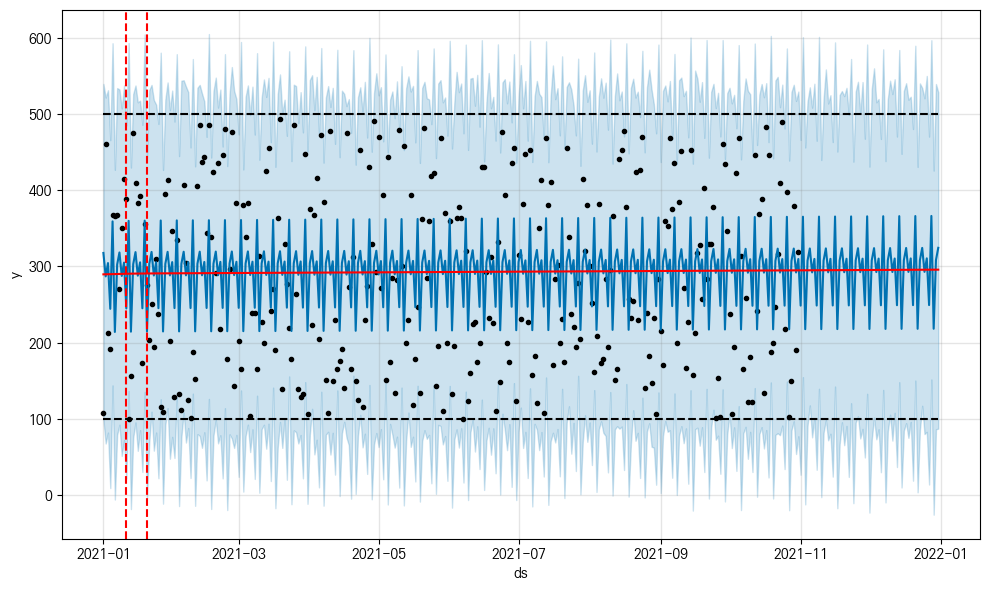

In [72]:
import pandas as pd
from prophet import Prophet

# ÏòàÏãú Îç∞Ïù¥ÌÑ∞
df = pd.DataFrame({
    'ds': pd.date_range(start='2021-01-01', end='2021-10-31'),
    'y': np.random.randint(100, 500, size=len(pd.date_range(start='2021-01-01', end='2021-10-31')))
})
# cap (ÏÉÅÌïú) Í∞í Ï∂îÍ∞Ä
df['cap'] = 500  # ÏòàÏãúÎ°ú ÏÉÅÌïúÏùÑ 500ÏúºÎ°ú ÏÑ§Ï†ï
# floor (ÌïòÌïú) Í∞í Ï∂îÍ∞Ä
df['floor'] = 100  # ÏòàÏãúÎ°ú ÌïòÌïúÏùÑ 100ÏúºÎ°ú ÏÑ§Ï†ï

# Ìú¥Ïùº Îç∞Ïù¥ÌÑ∞ (ÏòàÏãú)
holidays = pd.DataFrame({
    'holiday': 'christmas',
    'ds': pd.to_datetime(['2021-12-25', '2022-12-25']),
    'lower_window': 0,
    'upper_window': 1,
})

# Î™®Îç∏ ÏÉùÏÑ±
model = Prophet(
    growth='logistic', 
    changepoint_prior_scale=0.1, 
    seasonality_prior_scale=10.0,
    holidays=holidays,
    seasonality_mode='multiplicative',
    interval_width=0.95
)

# Î™®Îç∏ ÌïôÏäµ
model.fit(df)

# ÏòàÏ∏°Ìï† ÎØ∏Îûò ÎÇ†Ïßú ÏÉùÏÑ±
future = model.make_future_dataframe(periods=61)
# cap (ÏÉÅÌïú) Í∞í Ï∂îÍ∞Ä
future['cap'] = 500  # ÏòàÏãúÎ°ú ÏÉÅÌïúÏùÑ 500ÏúºÎ°ú ÏÑ§Ï†ï
# floor (ÌïòÌïú) Í∞í Ï∂îÍ∞Ä
future['floor'] = 100  # ÏòàÏãúÎ°ú ÌïòÌïúÏùÑ 100ÏúºÎ°ú ÏÑ§Ï†ï
# ÏòàÏ∏°
forecast = model.predict(future)

# ÏòàÏ∏° Í≤∞Í≥º ÏãúÍ∞ÅÌôî
fig = model.plot(forecast)
# Î≥ÄÌôîÏ†ê Ï∂îÍ∞Ä (Ï∂îÏÑ∏Í∞Ä Î∞îÎÄåÎäî ÏßÄÏ†ê ÌëúÏãú)
a = add_changepoints_to_plot(fig.gca(), model, forecast)
plt.show()

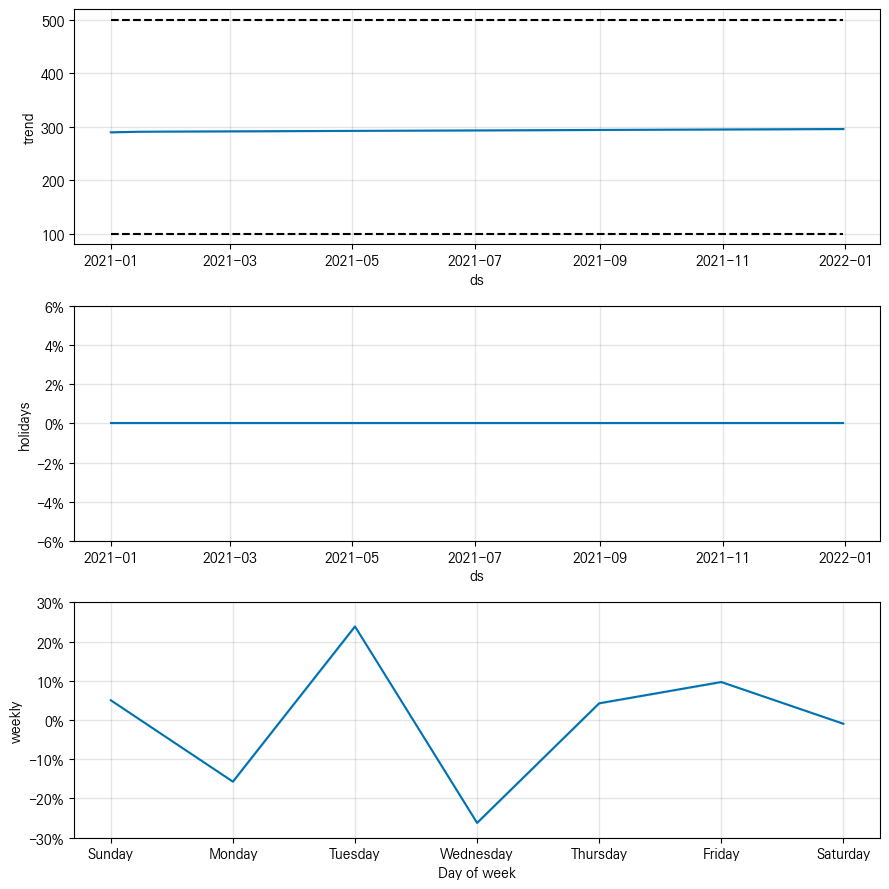

In [75]:
model.plot_components(forecast);

# Prophet ÏòàÏ∏° Ï∞®Ìä∏ Ìï¥ÏÑù Î∞©Î≤ï

1. Ïã§Ï†ú Îç∞Ïù¥ÌÑ∞ (Black dots / Black line)
- ÏùòÎØ∏: Ïù¥ Î∂ÄÎ∂ÑÏùÄ Î™®Îç∏Ïù¥ ÌïôÏäµÌïú Ïã§Ï†ú Îç∞Ïù¥ÌÑ∞Î•º ÎÇòÌÉÄÎÉÖÎãàÎã§. Ïã§Ï†ú Í∞íÏùÄ Í≤ÄÏùÄÏÉâ Ï†êÏúºÎ°ú ÌëúÏãúÎê©ÎãàÎã§.
- Ìï¥ÏÑù: ÏòàÏ∏° Î™®Îç∏Ïù¥ ÌïôÏäµÌïòÎäî ÎèôÏïà, Í≥ºÍ±∞Ïùò Í∞íÎì§ÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§. Ïù¥Î•º ÌÜµÌï¥ ÏòàÏ∏°ÌïòÍ≥†Ïûê ÌïòÎäî Í∞íÏùò Ìå®ÌÑ¥Í≥º Î≥ÄÌôîÎ•º Ïù¥Ìï¥Ìï† Ïàò ÏûàÏäµÎãàÎã§.

2. ÏòàÏ∏°Í∞í (Blue line - yhat)
- ÏùòÎØ∏: **ÌååÎûÄÏÉâ ÏÑ†** ÏùÄ Prophet Î™®Îç∏Ïù¥ ÏòàÏ∏°Ìïú ÎØ∏Îûò Í∞íÏùÑ ÎÇòÌÉÄÎÉÖÎãàÎã§. ProphetÏùÄ Í≥ºÍ±∞ Îç∞Ïù¥ÌÑ∞Î•º Í∏∞Î∞òÏúºÎ°ú ÎØ∏ÎûòÏóê Î∞úÏÉùÌï† Ïàò ÏûàÎäî Í∞íÏùÑ ÏòàÏ∏°Ìï©ÎãàÎã§.
- Ìï¥ÏÑù: Ïù¥ ÏÑ†ÏùÄ Î™®Îç∏Ïù¥ ÏòàÏ∏°Ìïú ÎØ∏ÎûòÏùò Ìä∏Î†åÎìúÎ•º ÎÇòÌÉÄÎÉÖÎãàÎã§. ÏòàÏ∏°Í∞íÏù¥ Ïã§Ï†ú Îç∞Ïù¥ÌÑ∞ÏôÄ ÏñºÎßàÎÇò ÏùºÏπòÌïòÎäîÏßÄÏóê Îî∞Îùº Î™®Îç∏Ïùò ÏòàÏ∏° ÏÑ±Îä•ÏùÑ ÌåêÎã®Ìï† Ïàò ÏûàÏäµÎãàÎã§.

3. Ïã†Î¢∞ Íµ¨Í∞Ñ (Shaded Area - yhat_lower, yhat_upper)
- ÏùòÎØ∏: ÏòàÏ∏°Í∞íÏóêÎäî Î∂àÌôïÏã§ÏÑ±Ïù¥ Ï°¥Ïû¨Ìï©ÎãàÎã§. ProphetÏùÄ ÏòàÏ∏°Í∞íÏùÑ Ïã†Î¢∞ Íµ¨Í∞ÑÏúºÎ°ú ÎÇòÌÉÄÎÉÖÎãàÎã§. Ïù¥ Ïã†Î¢∞ Íµ¨Í∞ÑÏùÄ ÏòàÏ∏°Í∞íÏù¥ Ïã§Ï†úÎ°ú Í∑∏ Íµ¨Í∞Ñ ÏïàÏóê ÏûàÏùÑ ÌôïÎ•†Ïù¥ ÎÜíÎã§Îäî Í≤ÉÏùÑ ÏùòÎØ∏Ìï©ÎãàÎã§.
- Ïã†Î¢∞ Íµ¨Í∞ÑÏùÄ ÌöåÏÉâ ÏùåÏòÅ ÏòÅÏó≠ÏúºÎ°ú ÌëúÏãúÎê©ÎãàÎã§:
    - yhat_lower: ÏòàÏ∏°Í∞íÏùò ÌïòÌïú
    - yhat_upper: ÏòàÏ∏°Í∞íÏùò ÏÉÅÌïú
- Ìï¥ÏÑù: Ïù¥ ÏòÅÏó≠ÏùÄ Î™®Îç∏Ïù¥ ÏòàÏ∏°ÌïòÎäî ÎØ∏Îûò Í∞íÏóê ÎåÄÌï¥ ÏñºÎßàÎÇò Î∂àÌôïÏã§ÌïúÏßÄÎ•º ÎÇòÌÉÄÎÉÖÎãàÎã§. 
    - Ï¢ÅÏùÄ Ïã†Î¢∞Íµ¨Í∞Ñ : ÏòàÏ∏°Í∞íÏóê ÎåÄÌïú **Î∂àÌôïÏã§ÏÑ±Ïù¥ Ï†ÅÎã§** Îäî ÏùòÎØ∏
    - ÎÑìÏùÄ Ïã†Î¢∞Íµ¨Í∞Ñ : ÏòàÏ∏°Í∞íÏóê ÎåÄÌïú **Î∂àÌôïÏã§ÏÑ±Ïù¥ ÌÅ¨Îã§** Îäî ÏùòÎØ∏

4. Ï∂îÏÑ∏ Î≥ÄÌôîÏ†ê (Changepoints - Red Dots)
- ÏùòÎØ∏: Prophet Î™®Îç∏ÏùÄ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Ï∂îÏÑ∏Í∞Ä Í∏âÍ≤©Ìûà Î≥ÄÌïòÎäî ÏãúÏ†êÏùÑ ÏûêÎèôÏúºÎ°ú Ï∞æÏïÑÎÉÖÎãàÎã§. Ïù¥ ÏãúÏ†êÏùÑ **Î≥ÄÌôîÏ†ê(changepoint)** Ïù¥ÎùºÍ≥† ÌïòÎ©∞, Í∑∏ÎûòÌîÑÏóêÏÑú Îπ®Í∞Ñ Ï†êÏúºÎ°ú ÌëúÏãúÎê©ÎãàÎã§.
- Ìï¥ÏÑù: Ï∂îÏÑ∏ Î≥ÄÌôîÏ†êÏùÄ Î™®Îç∏Ïù¥ Í≥ºÍ±∞ Îç∞Ïù¥ÌÑ∞Ïùò Î≥ÄÌôîÎ•º Í∞êÏßÄÌïú ÏßÄÏ†êÏûÖÎãàÎã§.
    - ÏòàÎ•º Îì§Ïñ¥, ÌåêÎß§ÎüâÏù¥ Í∞ëÏûêÍ∏∞ Ï¶ùÍ∞ÄÌïòÍ±∞ÎÇò Í∞êÏÜåÌïòÎäî ÏãúÏ†ê, Í∏∞ÌõÑÍ∞Ä Í∏âÎ≥ÄÌïòÎäî ÏãúÏ†ê Îì±Ïù¥ Îê† Ïàò ÏûàÏäµÎãàÎã§.
    - Ïù¥ ÏßÄÏ†êÎì§ÏùÄ ÎπÑÏ¶àÎãàÏä§ÏóêÏÑú Í∏âÍ≤©Ìïú Î≥ÄÌôîÍ∞Ä Î∞úÏÉùÌïòÎäî ÏãúÏ†êÏùº Ïàò ÏûàÏúºÎØÄÎ°ú Ï£ºÏùò ÍπäÍ≤å Î∂ÑÏÑùÌï¥Ïïº Ìï©ÎãàÎã§.